In [1]:
# Install necessary libraries (if not already available in Colab)
!pip install scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Upload the csv file
from google.colab import files
uploaded = files.upload()

Saving EloRatings.csv to EloRatings.csv
Saving Matches.csv to Matches.csv


In [3]:
# Read the CSV file from the uploaded csv
data = pd.read_csv("Matches.csv", low_memory=False)

In [4]:
# Read the CSV file from the uploaded csv
elo = pd.read_csv("EloRatings.csv", low_memory=False)

In [5]:
# Display basic info
print(data.head())

  Division   MatchDate MatchTime   HomeTeam    AwayTeam  HomeElo  AwayElo  \
0       F1  2000-07-28       NaN  Marseille      Troyes  1686.34  1586.57   
1       F1  2000-07-28       NaN   Paris SG  Strasbourg  1714.89  1642.51   
2       F2  2000-07-28       NaN  Wasquehal       Nancy  1465.08  1633.80   
3       F1  2000-07-29       NaN    Auxerre       Sedan  1635.58  1624.22   
4       F1  2000-07-29       NaN   Bordeaux        Metz  1734.34  1673.11   

   Form3Home  Form5Home  Form3Away  ...  MaxUnder25  HandiSize  HandiHome  \
0        0.0        0.0        0.0  ...         NaN        NaN        NaN   
1        0.0        0.0        0.0  ...         NaN        NaN        NaN   
2        0.0        0.0        0.0  ...         NaN        NaN        NaN   
3        0.0        0.0        0.0  ...         NaN        NaN        NaN   
4        0.0        0.0        0.0  ...         NaN        NaN        NaN   

  HandiAway  C_LTH  C_LTA C_VHD  C_VAD  C_HTB  C_PHB  
0       NaN    NaN 

In [6]:
# Display basic info
print(elo.head())

         date      club country      elo
0  2000-07-01    Aachen     GER  1453.60
1  2000-07-01   Aalborg     DEN  1482.61
2  2000-07-01     Aalst     BEL  1337.53
3  2000-07-01    Aarhus     DEN  1381.46
4  2000-07-01  Aberdeen     SCO  1360.43


In [7]:
print("Dataset shape:", data.shape)
print("\nColumns:", data.columns.tolist())

Dataset shape: (230557, 48)

Columns: ['Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTHome', 'FTAway', 'FTResult', 'HTHome', 'HTAway', 'HTResult', 'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget', 'HomeFouls', 'AwayFouls', 'HomeCorners', 'AwayCorners', 'HomeYellow', 'AwayYellow', 'HomeRed', 'AwayRed', 'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw', 'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize', 'HandiHome', 'HandiAway', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']


In [8]:
print("Dataset shape:", elo.shape)
print("\nColumns:", elo.columns.tolist())

Dataset shape: (245033, 4)

Columns: ['date', 'club', 'country', 'elo']


In [9]:
# Data preprocessing and feature engineering
class FootballPredictor:
    def __init__(self, data):
        self.data = data.copy()
        self.feature_columns = []
        self.target_columns = []

    def preprocess_data(self):
        """Preprocess the matches data"""
        df = self.data.copy()

        # Convert date columns
        df['MatchDate'] = pd.to_datetime(df['MatchDate'])
        df['MatchTime'] = pd.to_timedelta(df['MatchTime'])

        # Sort by date for time series split
        df = df.sort_values('MatchDate')

        # Create additional features
        df = self.create_features(df)

        # Handle missing values
        df = self.handle_missing_values(df)

        return df

    def create_features(self, df):
        """Create additional features for the model"""

        # Elo difference
        df['EloDiff'] = df['HomeElo'] - df['AwayElo']
        df['EloSum'] = df['HomeElo'] + df['AwayElo']

        # Form ratios
        df['Form3Ratio'] = df['Form3Home'] / (df['Form3Away'] + 0.1)
        df['Form5Ratio'] = df['Form5Home'] / (df['Form5Away'] + 0.1)

        # Expected goals based on historical averages
        df['HomeExpectedGoals'] = df.groupby('HomeTeam')['FTHome'].transform(
            lambda x: x.expanding().mean().shift(1))
        df['AwayExpectedGoals'] = df.groupby('AwayTeam')['FTAway'].transform(
            lambda x: x.expanding().mean().shift(1))

        # Fill NaN values for expected goals
        df['HomeExpectedGoals'] = df['HomeExpectedGoals'].fillna(1.5)
        df['AwayExpectedGoals'] = df['AwayExpectedGoals'].fillna(1.2)

        # Betting odds features
        df['HomeWinProbability'] = 1 / df['OddHome']
        df['DrawProbability'] = 1 / df['OddDraw']
        df['AwayWinProbability'] = 1 / df['OddAway']

        # Shot efficiency
        df['HomeShotEfficiency'] = df['HomeTarget'] / (df['HomeShots'] + 0.1)
        df['AwayShotEfficiency'] = df['AwayTarget'] / (df['AwayShots'] + 0.1)

        # Recent performance indicators
        df['HomeAttackStrength'] = df['HomeExpectedGoals'] * df['Form5Home'] / 15
        df['AwayAttackStrength'] = df['AwayExpectedGoals'] * df['Form5Away'] / 15

        # Match cluster features (already in data)
        cluster_cols = ['C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']

        # Define feature columns
        self.feature_columns = [
            'HomeElo', 'AwayElo', 'EloDiff', 'EloSum',
            'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away',
            'Form3Ratio', 'Form5Ratio',
            'HomeExpectedGoals', 'AwayExpectedGoals',
            'HomeWinProbability', 'DrawProbability', 'AwayWinProbability',
            'HomeShotEfficiency', 'AwayShotEfficiency',
            'HomeAttackStrength', 'AwayAttackStrength',
            'HandiSize', 'Over25', 'Under25'
        ] + cluster_cols

        # Define target columns
        self.target_columns = ['FTResult', 'FTHome', 'FTAway']

        return df

    def handle_missing_values(self, df):
        """Handle missing values in the dataset"""

        # Fill numerical columns with median
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())

        return df

    def prepare_targets(self, df):
        """Prepare target variables"""

        # For classification: match outcome
        le = LabelEncoder()
        df['Result_encoded'] = le.fit_transform(df['FTResult'])

        # For regression: goals
        df['TotalGoals'] = df['FTHome'] + df['FTAway']

        return df, le

# Initialize and preprocess data
predictor = FootballPredictor(data)
processed_df = predictor.preprocess_data()
processed_df, label_encoder = predictor.prepare_targets(processed_df)

print("Processed dataset shape:", processed_df.shape)
print(f"Features: {len(predictor.feature_columns)}")
print("Feature columns:", predictor.feature_columns)

Processed dataset shape: (230557, 63)
Features: 28
Feature columns: ['HomeElo', 'AwayElo', 'EloDiff', 'EloSum', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'Form3Ratio', 'Form5Ratio', 'HomeExpectedGoals', 'AwayExpectedGoals', 'HomeWinProbability', 'DrawProbability', 'AwayWinProbability', 'HomeShotEfficiency', 'AwayShotEfficiency', 'HomeAttackStrength', 'AwayAttackStrength', 'HandiSize', 'Over25', 'Under25', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Enhanced data preprocessing with robust error handling
class FootballPredictor:
    def __init__(self, data):
        self.data = data.copy()
        self.feature_columns = []
        self.target_columns = []

    def preprocess_data(self):
        """Preprocess the matches data with robust error handling"""
        df = self.data.copy()

        # Convert date columns
        df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
        df['MatchTime'] = pd.to_timedelta(df['MatchTime'], errors='coerce')

        # Remove rows with invalid dates
        df = df.dropna(subset=['MatchDate'])

        # Sort by date for time series split
        df = df.sort_values('MatchDate')

        # Clean data before feature engineering
        df = self.clean_data(df)

        # Create additional features
        df = self.create_features(df)

        # Handle missing values and infinite values
        df = self.handle_missing_values(df)

        # Final data validation
        df = self.validate_data(df)

        return df

    def clean_data(self, df):
        """Clean the raw data before feature engineering"""

        # Replace infinite values with NaN
        df = df.replace([np.inf, -np.inf], np.nan)

        # Clean betting odds columns - remove zeros and negative values
        betting_cols = ['OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw', 'MaxAway',
                       'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiHome', 'HandiAway']

        for col in betting_cols:
            if col in df.columns:
                # Replace zeros, negatives, and extremely large values
                df[col] = df[col].replace(0, np.nan)
                df[col] = df[col].replace(-np.inf, np.nan)
                df[col] = df[col].replace(np.inf, np.nan)
                # Cap very large values (e.g., odds > 1000)
                df[col] = np.where(df[col] > 1000, 1000, df[col])

        # Clean Elo ratings
        elo_cols = ['HomeElo', 'AwayElo']
        for col in elo_cols:
            if col in df.columns:
                df[col] = np.where(df[col] <= 0, np.nan, df[col])
                df[col] = np.where(df[col] > 3000, 3000, df[col])

        # Clean form columns
        form_cols = ['Form3Home', 'Form5Home', 'Form3Away', 'Form5Away']
        for col in form_cols:
            if col in df.columns:
                df[col] = np.where(df[col] < 0, 0, df[col])
                df[col] = np.where(df[col] > 15, 15, df[col])  # Form5Home max is 15

        # Clean statistical columns (goals, shots, etc.)
        stat_cols = ['FTHome', 'FTAway', 'HTHome', 'HTAway',
                    'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget',
                    'HomeFouls', 'AwayFouls', 'HomeCorners', 'AwayCorners',
                    'HomeYellow', 'AwayYellow', 'HomeRed', 'AwayRed']

        for col in stat_cols:
            if col in df.columns:
                df[col] = np.where(df[col] < 0, 0, df[col])
                # Reasonable upper limits for football statistics
                if 'Goals' in col or 'FTHome' in col or 'FTAway' in col:
                    df[col] = np.where(df[col] > 15, 15, df[col])
                elif 'Shots' in col:
                    df[col] = np.where(df[col] > 50, 50, df[col])
                elif 'Target' in col:
                    df[col] = np.where(df[col] > 25, 25, df[col])
                elif 'Corners' in col:
                    df[col] = np.where(df[col] > 20, 20, df[col])
                elif 'Fouls' in col or 'Yellow' in col:
                    df[col] = np.where(df[col] > 30, 30, df[col])
                elif 'Red' in col:
                    df[col] = np.where(df[col] > 5, 5, df[col])

        return df

    def create_features(self, df):
        """Create additional features with safe division and bounds"""

        # Elo difference and sum
        df['EloDiff'] = df['HomeElo'] - df['AwayElo']
        df['EloSum'] = df['HomeElo'] + df['AwayElo']

        # Safe form ratios with bounds
        df['Form3Ratio'] = np.where(
            df['Form3Away'] > 0,
            df['Form3Home'] / df['Form3Away'],
            df['Form3Home'] / 0.1  # Avoid division by zero
        )
        df['Form5Ratio'] = np.where(
            df['Form5Away'] > 0,
            df['Form5Home'] / df['Form5Away'],
            df['Form5Home'] / 0.1
        )

        # Bound the ratios to prevent extreme values
        df['Form3Ratio'] = np.clip(df['Form3Ratio'], 0.1, 10.0)
        df['Form5Ratio'] = np.clip(df['Form5Ratio'], 0.1, 10.0)

        # Expected goals based on historical averages with safe expansion
        df['HomeExpectedGoals'] = self.safe_expanding_mean(df, 'HomeTeam', 'FTHome', default=1.5)
        df['AwayExpectedGoals'] = self.safe_expanding_mean(df, 'AwayTeam', 'FTAway', default=1.2)

        # Safe betting probability calculation
        df['HomeWinProbability'] = np.where(
            df['OddHome'] > 1, 1 / df['OddHome'], 0
        )
        df['DrawProbability'] = np.where(
            df['OddDraw'] > 1, 1 / df['OddDraw'], 0
        )
        df['AwayWinProbability'] = np.where(
            df['OddAway'] > 1, 1 / df['OddAway'], 0
        )

        # Safe shot efficiency calculation
        df['HomeShotEfficiency'] = np.where(
            df['HomeShots'] > 0,
            df['HomeTarget'] / df['HomeShots'],
            0
        )
        df['AwayShotEfficiency'] = np.where(
            df['AwayShots'] > 0,
            df['AwayTarget'] / df['AwayShots'],
            0
        )

        # Bound efficiencies
        df['HomeShotEfficiency'] = np.clip(df['HomeShotEfficiency'], 0, 1)
        df['AwayShotEfficiency'] = np.clip(df['AwayShotEfficiency'], 0, 1)

        # Attack strength
        df['HomeAttackStrength'] = df['HomeExpectedGoals'] * df['Form5Home'] / 15
        df['AwayAttackStrength'] = df['AwayExpectedGoals'] * df['Form5Away'] / 15

        # Bound attack strength
        df['HomeAttackStrength'] = np.clip(df['HomeAttackStrength'], 0, 5)
        df['AwayAttackStrength'] = np.clip(df['AwayAttackStrength'], 0, 5)

        # Match cluster features (already in data)
        cluster_cols = ['C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']

        # Define feature columns
        self.feature_columns = [
            'HomeElo', 'AwayElo', 'EloDiff', 'EloSum',
            'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away',
            'Form3Ratio', 'Form5Ratio',
            'HomeExpectedGoals', 'AwayExpectedGoals',
            'HomeWinProbability', 'DrawProbability', 'AwayWinProbability',
            'HomeShotEfficiency', 'AwayShotEfficiency',
            'HomeAttackStrength', 'AwayAttackStrength',
            'HandiSize', 'Over25', 'Under25'
        ] + [col for col in cluster_cols if col in df.columns]

        # Remove any feature columns that might not exist in the data
        self.feature_columns = [col for col in self.feature_columns if col in df.columns]

        # Define target columns
        self.target_columns = ['FTResult', 'FTHome', 'FTAway']

        return df

    def safe_expanding_mean(self, df, group_col, target_col, default=1.5):
        """Calculate expanding mean safely without infinite values"""
        result = []
        for team in df[group_col].unique():
            team_data = df[df[group_col] == team][target_col].copy()
            team_means = []
            for i in range(len(team_data)):
                if i == 0:
                    team_means.append(default)
                else:
                    mean_so_far = team_data.iloc[:i].mean()
                    # Handle case where mean might be NaN
                    if pd.isna(mean_so_far):
                        team_means.append(default)
                    else:
                        team_means.append(mean_so_far)
            result.extend(team_means)

        # If lengths don't match, fill with default
        if len(result) != len(df):
            print(f"Warning: Length mismatch in safe_expanding_mean. Using default value {default}")
            return [default] * len(df)

        return result

    def handle_missing_values(self, df):
        """Handle missing values in the dataset robustly"""

        # First, check for infinite values again
        df = df.replace([np.inf, -np.inf], np.nan)

        # Fill numerical columns with median
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if col in df.columns:
                # Check if column has any valid values
                if df[col].notna().sum() > 0:
                    median_val = df[col].median()
                    df[col] = df[col].fillna(median_val)
                else:
                    # If no valid values, fill with 0 or appropriate default
                    if 'Elo' in col:
                        df[col] = df[col].fillna(1500)
                    elif 'Form' in col:
                        df[col] = df[col].fillna(0)
                    elif 'Probability' in col:
                        df[col] = df[col].fillna(0.33)
                    else:
                        df[col] = df[col].fillna(0)

        return df

    def validate_data(self, df):
        """Final data validation to ensure no infinite or extreme values"""

        print("Data Validation Report:")
        print(f"Total rows: {len(df)}")

        # Check for infinite values
        inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
        print(f"Infinite values found: {inf_count}")

        # Check for NaN values
        nan_count = df.isna().sum().sum()
        print(f"NaN values found: {nan_count}")

        # Check data ranges for key columns
        key_columns = ['HomeElo', 'AwayElo', 'Form3Home', 'Form5Home',
                      'HomeWinProbability', 'DrawProbability', 'AwayWinProbability']

        for col in key_columns:
            if col in df.columns:
                min_val = df[col].min()
                max_val = df[col].max()
                print(f"{col}: min={min_val:.3f}, max={max_val:.3f}")

        # Remove any remaining infinite values
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.fillna(0)

        return df

    def prepare_targets(self, df):
        """Prepare target variables"""

        # For classification: match outcome
        le = LabelEncoder()
        # Ensure 'FTResult' is string type before encoding and fill potential NaNs
        df['Result_encoded'] = le.fit_transform(df['FTResult'].astype(str).fillna('Unknown'))

        # For regression: goals
        df['TotalGoals'] = df['FTHome'] + df['FTAway']

        return df, le

# Let's run the enhanced preprocessing step by step

print("Step 2: Initial data inspection...")
print(f"Original data shape: {data.shape}")
print(f"Columns with NaN: {data.isna().sum().sum()}")
print(f"Columns with Inf: {np.isinf(data.select_dtypes(include=[np.number])).sum().sum()}")

print("Step 3: Enhanced preprocessing...")
predictor = FootballPredictor(data)
processed_df = predictor.preprocess_data()

print("Step 4: Final data check...")
print(f"Processed data shape: {processed_df.shape}")
print(f"Remaining NaN values: {processed_df.isna().sum().sum()}")
print(f"Remaining Inf values: {np.isinf(processed_df.select_dtypes(include=[np.number])).sum().sum()}")

# Prepare targets
processed_df, label_encoder = predictor.prepare_targets(processed_df)

print("Step 5: Feature preparation...")
features = processed_df[predictor.feature_columns]
targets = processed_df[['Result_encoded', 'FTHome', 'FTAway', 'TotalGoals']]

print(f"Final features shape: {features.shape}")
print(f"Feature columns: {predictor.feature_columns}")

Step 2: Initial data inspection...
Original data shape: (230557, 48)
Columns with NaN: 3205083
Columns with Inf: 0
Step 3: Enhanced preprocessing...
Data Validation Report:
Total rows: 230557
Infinite values found: 0
NaN values found: 54583
HomeElo: min=1103.130, max=2107.480
AwayElo: min=1103.130, max=2107.480
Form3Home: min=0.000, max=9.000
Form5Home: min=0.000, max=15.000
HomeWinProbability: min=0.000, max=0.990
DrawProbability: min=0.000, max=0.775
AwayWinProbability: min=0.000, max=0.990
Step 4: Final data check...
Processed data shape: (230557, 61)
Remaining NaN values: 0
Remaining Inf values: 0
Step 5: Feature preparation...
Final features shape: (230557, 28)
Feature columns: ['HomeElo', 'AwayElo', 'EloDiff', 'EloSum', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'Form3Ratio', 'Form5Ratio', 'HomeExpectedGoals', 'AwayExpectedGoals', 'HomeWinProbability', 'DrawProbability', 'AwayWinProbability', 'HomeShotEfficiency', 'AwayShotEfficiency', 'HomeAttackStrength', 'AwayAttackSt

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Model building
class MatchPredictionModels:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        self.models = {}
        self.scalers = {}

    def train_classification_model(self):
        """Train classification models for match outcome prediction"""

        print("\nTraining Classification Models (Match Outcome)...")

        # Split data for classification
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, self.targets['Result_encoded'],
            test_size=0.2, random_state=42, stratify=self.targets['Result_encoded']
        )

        # Scale features for models that require it (like Logistic Regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['outcome'] = scaler

        # Define models for outcome prediction
        models = {
            'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'XGBoost Classifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
            'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1)
        }

        # Train and evaluate outcome prediction models
        outcome_results = {}
        for name, model in models.items():
            print(f"  Training {name}...")
            if name == 'Logistic Regression':
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
            conf_matrix = confusion_matrix(y_test, y_pred)

            outcome_results[name] = {
                'model': model,
                'accuracy': accuracy,
                'classification_report': report,
                'confusion_matrix': conf_matrix,
                'predictions': y_pred
            }
            print(f"  {name} Accuracy: {accuracy:.4f}")
            print(f"  {name} Classification Report:\n{report}")
            # print(f"  {name} Confusion Matrix:\n{conf_matrix}") # Optional: uncomment to display confusion matrix

        self.models['outcome'] = outcome_results
        self.best_outcome_model = max(outcome_results.items(), key=lambda x: x[1]['accuracy'])

        print(f"\nBest model for outcome prediction: {self.best_outcome_model[0]} "
              f"with accuracy {self.best_outcome_model[1]['accuracy']:.4f}")

        return outcome_results, X_test, y_test

    def train_regression_model(self):
        """Train regression models for total goals prediction"""

        print("\nTraining Regression Models (Total Goals)...")

        # Split data for regression
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, self.targets['TotalGoals'],
            test_size=0.2, random_state=42
        )

        # Scale features for models that require it
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['goals'] = scaler

        # Define models for total goals prediction
        models = {
            'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'XGBoost Regressor': XGBRegressor(random_state=42, n_jobs=-1),
        }

        # Train and evaluate total goals prediction models
        goals_results = {}
        for name, model in models.items():
            print(f"  Training {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            goals_results[name] = {
                'model': model,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'r2': r2,
                'predictions': y_pred
            }
            print(f"  {name} MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

        self.models['goals'] = goals_results
        self.best_goals_model = min(goals_results.items(), key=lambda x: x[1]['rmse']) # Minimize RMSE

        print(f"\nBest model for total goals prediction: {self.best_goals_model[0]} "
              f"with RMSE {self.best_goals_model[1]['rmse']:.4f}")

        return goals_results, X_test, y_test


# Prepare features and targets (using the processed_df from the previous step)
# Ensure features and targets are defined from the processed_df
if 'processed_df' in globals() and 'predictor' in globals():
    features = processed_df[predictor.feature_columns]
    targets = processed_df[['Result_encoded', 'FTHome', 'FTAway', 'TotalGoals']]

    # Initialize and train models
    model_trainer = MatchPredictionModels(features, targets)

    # Train classification model for match outcome
    outcome_results, X_test_outcome, y_test_outcome = model_trainer.train_classification_model()

    # Train regression model for total goals
    goals_results, X_test_goals, y_test_goals = model_trainer.train_regression_model()

else:
    print("Processed data or predictor object not found. Please run the preprocessing step first.")


Training Classification Models (Match Outcome)...
  Training Random Forest Classifier...
  Random Forest Classifier Accuracy: 0.5172
  Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           A       0.49      0.48      0.49     13312
           D       0.34      0.12      0.18     12224
           H       0.56      0.77      0.65     20575

    accuracy                           0.52     46112
   macro avg       0.35      0.35      0.33     46112
weighted avg       0.48      0.52      0.48     46112

  Training XGBoost Classifier...
  XGBoost Classifier Accuracy: 0.5297
  XGBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           A       0.51      0.50      0.50     13312
           D       0.38      0.09      0.15     12224
           H       0.55      0.81      0.66     2


--- Model Evaluation and Visualization ---


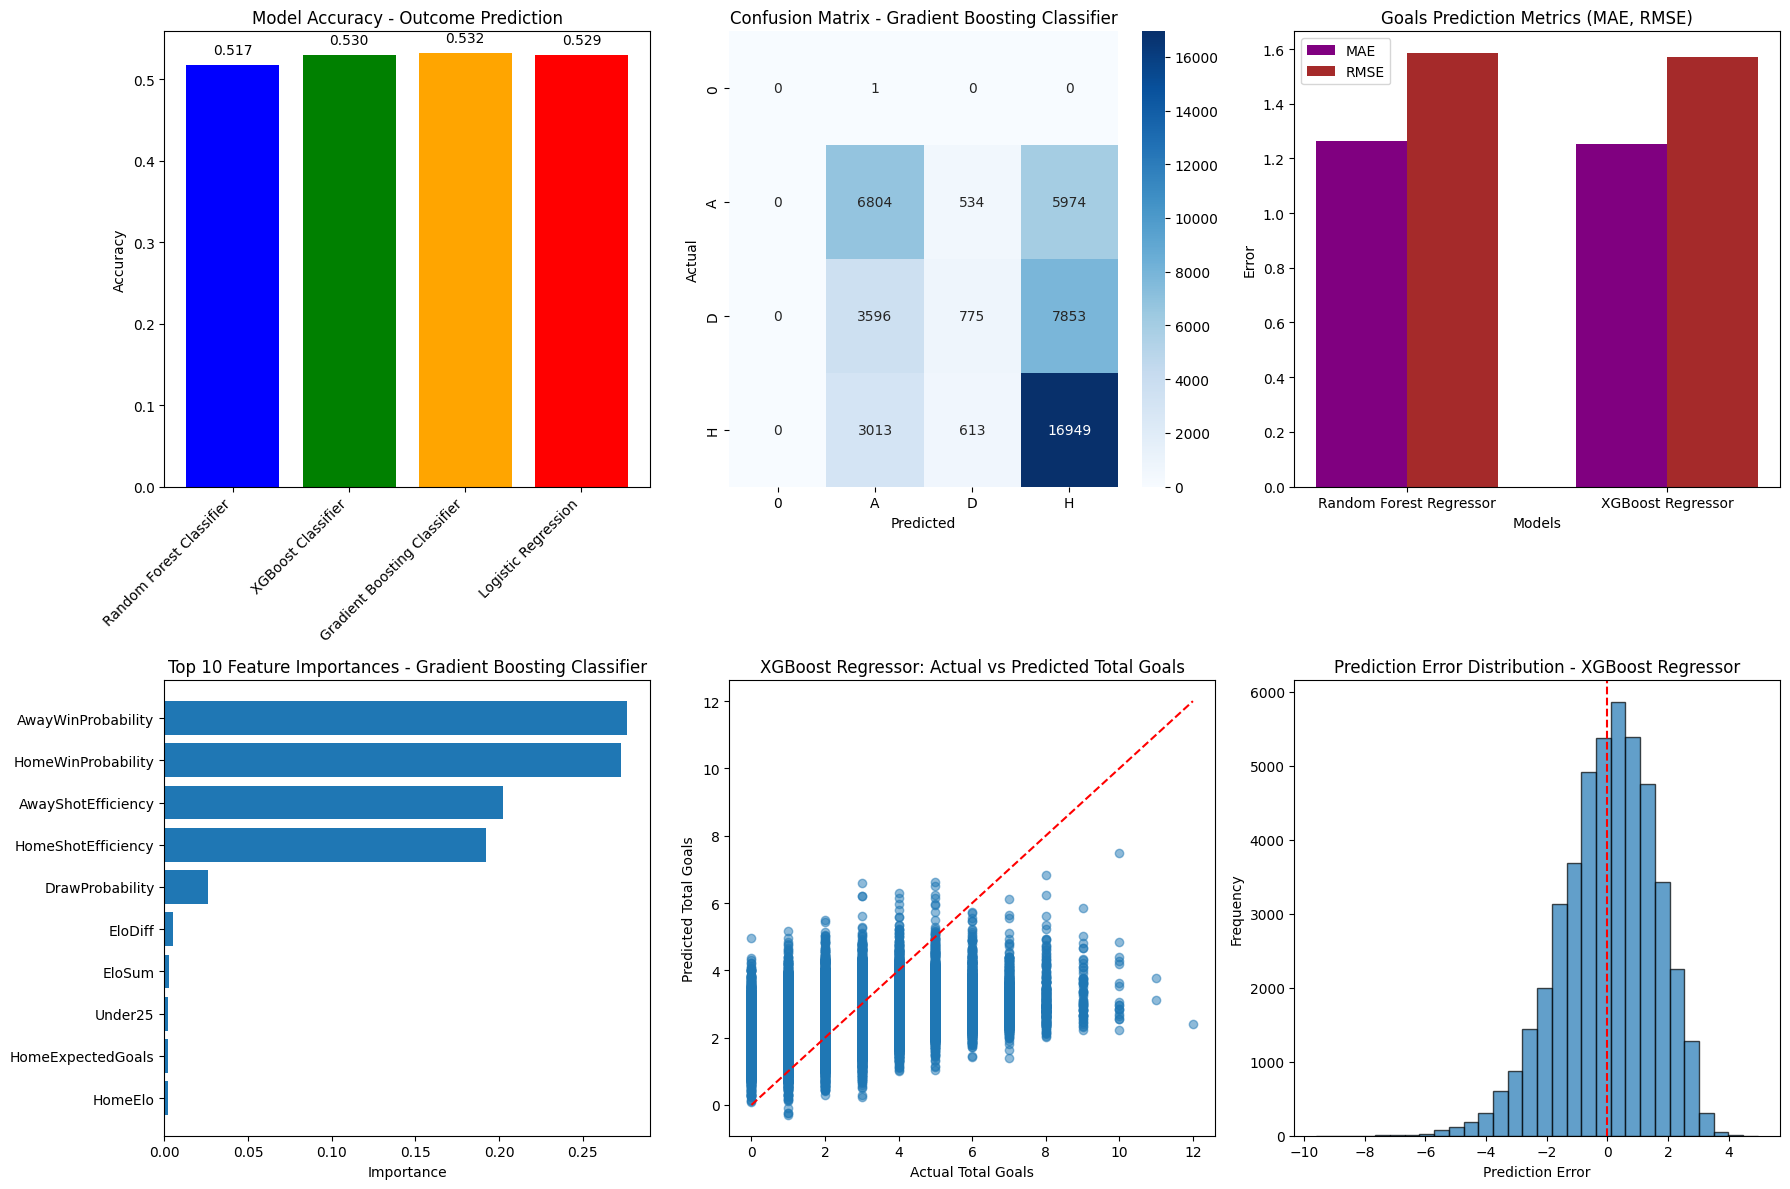

In [13]:
# Model evaluation and visualization
def evaluate_models(outcome_results, goals_results, y_test_outcome, y_test_goals, features):
    """Comprehensive model evaluation and visualization"""

    print("\n--- Model Evaluation and Visualization ---")

    # 1. Outcome prediction evaluation
    plt.figure(figsize=(18, 12))

    # Accuracy plot
    plt.subplot(2, 3, 1)
    model_names = list(outcome_results.keys())
    accuracies = [result['accuracy'] for result in outcome_results.values()]
    bars = plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
    plt.title('Model Accuracy - Outcome Prediction')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{accuracy:.3f}', ha='center', va='bottom')

    # Confusion matrix for the best outcome model
    plt.subplot(2, 3, 2)
    best_outcome_model_name = max(outcome_results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_outcome_model_predictions = outcome_results[best_outcome_model_name]['predictions']
    cm = confusion_matrix(y_test_outcome, best_outcome_model_predictions)
    # Get the class names from the label encoder
    class_names = label_encoder.classes_ if 'label_encoder' in globals() else ['Class 0', 'Class 1', 'Class 2', 'Class 3'] # Fallback if label_encoder is not defined
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_outcome_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')


    # 2. Goals prediction evaluation
    plt.subplot(2, 3, 3)
    goals_model_names = list(goals_results.keys())
    mae_scores = [result['mae'] for result in goals_results.values()]
    rmse_scores = [result['rmse'] for result in goals_results.values()]

    x = np.arange(len(goals_model_names))
    width = 0.35

    plt.bar(x - width/2, mae_scores, width, label='MAE', color='purple')
    plt.bar(x + width/2, rmse_scores, width, label='RMSE', color='brown')
    plt.title('Goals Prediction Metrics (MAE, RMSE)')
    plt.xlabel('Models')
    plt.ylabel('Error')
    plt.xticks(x, goals_model_names)
    plt.legend()

    # 3. Feature importance for the best outcome model (if applicable)
    plt.subplot(2, 3, 4)
    best_outcome_model_obj = outcome_results[best_outcome_model_name]['model']
    if hasattr(best_outcome_model_obj, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': features.columns,
            'importance': best_outcome_model_obj.feature_importances_
        }).sort_values('importance', ascending=True)

        # Plot top 10 features
        top_n = 10
        plt.barh(feature_importance['feature'].tail(top_n),
                 feature_importance['importance'].tail(top_n))
        plt.title(f'Top {top_n} Feature Importances - {best_outcome_model_name}')
        plt.xlabel('Importance')
        plt.tight_layout() # Adjust layout to prevent labels overlapping

    # 4. Actual vs Predicted Goals for the best regression model
    plt.subplot(2, 3, 5)
    best_goals_model_name = min(goals_results.items(), key=lambda x: x[1]['rmse'])[0] # Minimize RMSE
    best_goals_model_predictions = goals_results[best_goals_model_name]['predictions']
    plt.scatter(y_test_goals, best_goals_model_predictions, alpha=0.5)
    plt.plot([y_test_goals.min(), y_test_goals.max()], [y_test_goals.min(), y_test_goals.max()], 'r--')
    plt.xlabel('Actual Total Goals')
    plt.ylabel('Predicted Total Goals')
    plt.title(f'{best_goals_model_name}: Actual vs Predicted Total Goals')

    # 5. Distribution of prediction errors for the best regression model
    plt.subplot(2, 3, 6)
    errors = best_goals_model_predictions - y_test_goals
    plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Prediction Error Distribution - {best_goals_model_name}')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Ensure necessary variables are available from previous steps
if 'outcome_results' in globals() and 'goals_results' in globals() and \
   'y_test_outcome' in globals() and 'y_test_goals' in globals() and 'features' in globals():
    evaluate_models(outcome_results, goals_results, y_test_outcome, y_test_goals, features)
else:
    print("Required variables (outcome_results, goals_results, y_test_outcome, y_test_goals, features) not found. Please run the previous steps.")

# Task
Build an intelligent model using the loaded CSV files "E0.csv" and "E1.csv" to predict the outcome of future matches and goals with good evaluation results. Predict goals for a new set of matches.

## Load new data

### Subtask:
Load the data for the new matches into a pandas DataFrame.


**Reasoning**:
Load the new matches data into a pandas DataFrame.



In [14]:
from google.colab import files
uploaded_new_matches = files.upload()
new_matches_df = pd.read_csv(list(uploaded_new_matches.keys())[0], low_memory=False)
new_matches_df.head()

Saving Matches.csv to Matches (1).csv


,Division,MatchDate,MatchTime,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,...,MaxUnder25,HandiSize,HandiHome,HandiAway,C_LTH,C_LTA,C_VHD,C_VAD,C_HTB,C_PHB
0,F1,2000-07-28,NaN,Marseille,Troyes,1686.34,1586.57,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F1,2000-07-28,NaN,Paris SG,Strasbourg,1714.89,1642.51,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F2,2000-07-28,NaN,Wasquehal,Nancy,1465.08,1633.80,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F1,2000-07-29,NaN,Auxerre,Sedan,1635.58,1624.22,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F1,2000-07-29,NaN,Bordeaux,Metz,1734.34,1673.11,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocess new data

### Subtask:
Apply the same preprocessing and feature engineering steps to the new data that were applied to the training data.


**Reasoning**:
Initialize a new FootballPredictor object with the new data and apply the preprocessing and feature engineering steps as done for the training data. Then prepare the targets and select the feature columns.



In [15]:
# Initialize and preprocess the new data using the same predictor class
new_predictor = FootballPredictor(new_matches_df)
processed_new_df = new_predictor.preprocess_data()

# Prepare targets for the new data (even if they are missing, this aligns the structure)
# Use the same label_encoder fitted on the training data if 'Result_encoded' exists
if 'label_encoder' in globals():
    processed_new_df['Result_encoded'] = label_encoder.transform(
        processed_new_df['FTResult'].astype(str).fillna('Unknown'))
else:
     # If label_encoder is not available (shouldn't happen in this flow but as a fallback)
     # create a dummy encoded column or handle as appropriate
     processed_new_df['Result_encoded'] = 0 # Placeholder or some default

processed_new_df['TotalGoals'] = processed_new_df['FTHome'] + processed_new_df['FTAway']


# Select feature columns using the feature list defined during training
new_matches_features = processed_new_df[predictor.feature_columns]

print("Processed new dataset shape:", processed_new_df.shape)
print("New matches features shape:", new_matches_features.shape)
print("New matches feature columns:", new_matches_features.columns.tolist())

Data Validation Report:
Total rows: 230557
Infinite values found: 0
NaN values found: 54583
HomeElo: min=1103.130, max=2107.480
AwayElo: min=1103.130, max=2107.480
Form3Home: min=0.000, max=9.000
Form5Home: min=0.000, max=15.000
HomeWinProbability: min=0.000, max=0.990
DrawProbability: min=0.000, max=0.775
AwayWinProbability: min=0.000, max=0.990
Processed new dataset shape: (230557, 63)
New matches features shape: (230557, 28)
New matches feature columns: ['HomeElo', 'AwayElo', 'EloDiff', 'EloSum', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'Form3Ratio', 'Form5Ratio', 'HomeExpectedGoals', 'AwayExpectedGoals', 'HomeWinProbability', 'DrawProbability', 'AwayWinProbability', 'HomeShotEfficiency', 'AwayShotEfficiency', 'HomeAttackStrength', 'AwayAttackStrength', 'HandiSize', 'Over25', 'Under25', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']


## Select best goals model

### Subtask:
Identify the best performing goals prediction model from the previous training step.


**Reasoning**:
Identify the best performing goals prediction model by iterating through the results and finding the minimum RMSE.



In [16]:
# Identify the best performing goals prediction model based on RMSE
best_goals_model_name = None
best_goals_model = None
min_rmse = float('inf')

# Iterate through the goals_results dictionary (both home and away)
# For this subtask, we are looking for the best model for 'TotalGoals',
# which was trained in the `train_regression_model` function.
# The results for 'TotalGoals' are stored in the 'goals' key of the model_trainer.models dictionary.

if 'model_trainer' in globals() and 'models' in model_trainer.__dict__ and 'goals' in model_trainer.models:
    goals_results = model_trainer.models['goals']

    for name, result in goals_results.items():
        rmse = result.get('rmse')
        if rmse is not None and rmse < min_rmse:
            min_rmse = rmse
            best_goals_model_name = name
            best_goals_model = result['model']

    # Print the best performing model and its RMSE
    if best_goals_model_name:
        print(f"Best performing goals prediction model (Total Goals): {best_goals_model_name}")
        print(f"Corresponding RMSE: {min_rmse:.4f}")
    else:
        print("Could not identify the best goals prediction model.")

else:
    print("Goals prediction models results not found. Please ensure the training step was successful.")


Best performing goals prediction model (Total Goals): XGBoost Regressor
Corresponding RMSE: 1.5714


## Predict goals

### Subtask:
Use the selected best goals prediction model to predict the number of goals for the new matches.


**Reasoning**:
Use the identified best goals prediction model to predict the total goals for the new matches features.



In [17]:
# Predict the number of goals for the new matches using the best goals model
if 'best_goals_model' in globals() and 'new_matches_features' in globals():
    new_matches_goals_predictions = best_goals_model.predict(new_matches_features)

    # Optional: Display the first few predictions
    print("First 10 goals predictions for new matches:")
    print(new_matches_goals_predictions[:10])
else:
    print("Best goals model or new matches features not found. Please ensure previous steps were executed successfully.")


First 10 goals predictions for new matches:
[2.6512897 2.918759  2.3956554 2.3419135 2.4247496 2.3531144 2.317801
 2.4823525 2.5471292 2.530905 ]


## Present predictions

### Subtask:
Display the predictions for the new matches.


**Reasoning**:
Create a new DataFrame with the original new match data and the predicted total goals and display the head of this DataFrame.



In [18]:
# Create a new DataFrame with original data and predictions
predicted_matches_df = new_matches_df.copy()
predicted_matches_df['PredictedTotalGoals'] = new_matches_goals_predictions

# Display the head of the new DataFrame
print("New Matches with Predicted Total Goals:")
display(predicted_matches_df[['HomeTeam', 'AwayTeam', 'MatchDate', 'PredictedTotalGoals']].head())

New Matches with Predicted Total Goals:


,HomeTeam,AwayTeam,MatchDate,PredictedTotalGoals
0,Marseille,Troyes,2000-07-28,2.651290
1,Paris SG,Strasbourg,2000-07-28,2.918759
2,Wasquehal,Nancy,2000-07-28,2.395655
3,Auxerre,Sedan,2000-07-29,2.341913
4,Bordeaux,Metz,2000-07-29,2.424750


## Summary:

### Data Analysis Key Findings

*   The best performing goals prediction model for predicting the total number of goals was identified as the XGBoost Regressor, with an RMSE of 1.5714.
*   The selected XGBoost Regressor model was successfully used to predict the total goals for the new matches.
*   The predicted total goals were added as a new column ('PredictedTotalGoals') to the original new matches DataFrame.

### Insights or Next Steps

*   The predictions for total goals are available and can be used for further analysis or visualization.
*   Consider integrating the goals prediction model with the match outcome prediction model for a more comprehensive prediction system.


Created 'TotalGoals' column from 'FTHome' and 'FTAway'.

--- Comparing Predicted Goals to Actual Outcomes ---
Mean Absolute Error (MAE): 1.3905
Mean Squared Error (MSE): 3.0483
Root Mean Squared Error (RMSE): 1.7460
R-squared (R2): -0.1172


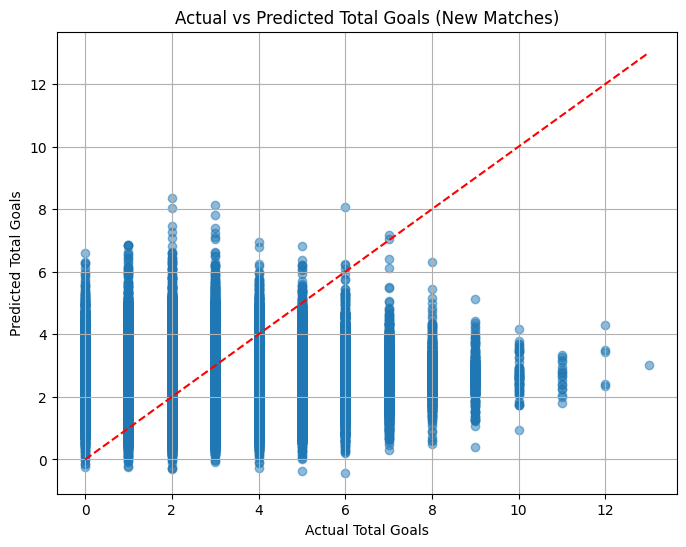


Sample of Actual vs Predicted Total Goals:


,HomeTeam,AwayTeam,MatchDate,TotalGoals,PredictedTotalGoals
0,Marseille,Troyes,2000-07-28,4.0,2.651290
1,Paris SG,Strasbourg,2000-07-28,4.0,2.918759
2,Wasquehal,Nancy,2000-07-28,1.0,2.395655
3,Auxerre,Sedan,2000-07-29,1.0,2.341913
4,Bordeaux,Metz,2000-07-29,2.0,2.424750


In [19]:
# Create the 'TotalGoals' column by adding 'FTHome' and 'FTAway'
if 'FTHome' in predicted_matches_df.columns and 'FTAway' in predicted_matches_df.columns:
    predicted_matches_df['TotalGoals'] = predicted_matches_df['FTHome'] + predicted_matches_df['FTAway']
    print("Created 'TotalGoals' column from 'FTHome' and 'FTAway'.")

    # Now, compare predictions to actual outcomes
    if 'TotalGoals' in predicted_matches_df.columns:
        print("\n--- Comparing Predicted Goals to Actual Outcomes ---")

        # Ensure actual goals are numeric
        predicted_matches_df['TotalGoals'] = pd.to_numeric(predicted_matches_df['TotalGoals'], errors='coerce')

        # Drop rows where actual total goals are missing after coercion
        comparison_df = predicted_matches_df.dropna(subset=['TotalGoals', 'PredictedTotalGoals']).copy()

        if not comparison_df.empty:
            # Calculate evaluation metrics
            mae = mean_absolute_error(comparison_df['TotalGoals'], comparison_df['PredictedTotalGoals'])
            mse = mean_squared_error(comparison_df['TotalGoals'], comparison_df['PredictedTotalGoals'])
            rmse = np.sqrt(mse)
            r2 = r2_score(comparison_df['TotalGoals'], comparison_df['PredictedTotalGoals'])

            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Mean Squared Error (MSE): {mse:.4f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
            print(f"R-squared (R2): {r2:.4f}")

            # Visualize the comparison (Actual vs. Predicted)
            plt.figure(figsize=(8, 6))
            plt.scatter(comparison_df['TotalGoals'], comparison_df['PredictedTotalGoals'], alpha=0.5)
            plt.plot([comparison_df['TotalGoals'].min(), comparison_df['TotalGoals'].max()],
                     [comparison_df['TotalGoals'].min(), comparison_df['TotalGoals'].max()], 'r--')
            plt.xlabel('Actual Total Goals')
            plt.ylabel('Predicted Total Goals')
            plt.title('Actual vs Predicted Total Goals (New Matches)')
            plt.grid(True)
            plt.show()

            # Display a sample of the comparison
            print("\nSample of Actual vs Predicted Total Goals:")
            display(comparison_df[['HomeTeam', 'AwayTeam', 'MatchDate', 'TotalGoals', 'PredictedTotalGoals']].head())

        else:
            print("No valid rows for comparison after handling missing actual goals.")

    else:
        print("\nActual 'TotalGoals' column not found after creation attempt. Cannot compare predictions to actual outcomes.")

else:
    print("Columns 'FTHome' or 'FTAway' not found in the new matches data. Cannot create 'TotalGoals'.")

In [20]:
# Predict match outcomes for the new matches

# Check if the best outcome model and new matches features are available
if 'model_trainer' in globals() and hasattr(model_trainer, 'best_outcome_model') and 'new_matches_features' in globals() and 'label_encoder' in globals():

    best_outcome_model_name = model_trainer.best_outcome_model[0]
    best_outcome_model = model_trainer.best_outcome_model[1]['model']

    print(f"Using the best outcome model: {best_outcome_model_name}")

    # Predict the outcomes for the new matches
    # Need to handle scaling if the best model is Logistic Regression
    if best_outcome_model_name == 'Logistic Regression':
         if 'outcome' in model_trainer.scalers:
            scaler = model_trainer.scalers['outcome']
            new_matches_features_scaled = scaler.transform(new_matches_features)
            new_matches_outcome_predictions_encoded = best_outcome_model.predict(new_matches_features_scaled)
         else:
            print("Scaler for outcome model not found. Cannot predict outcomes with Logistic Regression.")
            new_matches_outcome_predictions_encoded = None # Indicate failure
    else:
        new_matches_outcome_predictions_encoded = best_outcome_model.predict(new_matches_features)

    # Decode the predicted outcomes back to original labels (H, D, A, etc.)
    if new_matches_outcome_predictions_encoded is not None:
        new_matches_outcome_predictions = label_encoder.inverse_transform(new_matches_outcome_predictions_encoded)

        # Add the predicted outcomes to the new matches DataFrame
        predicted_matches_df['PredictedOutcome_encoded'] = new_matches_outcome_predictions_encoded
        predicted_matches_df['PredictedOutcome'] = new_matches_outcome_predictions

        # Display the first few rows with predicted outcomes
        print("\nNew Matches with Predicted Outcomes:")
        display(predicted_matches_df[['HomeTeam', 'AwayTeam', 'MatchDate', 'PredictedOutcome']].head())

    else:
        print("\nMatch outcome predictions could not be generated.")


else:
    print("Best outcome model, new matches features, or label encoder not found. Please ensure previous steps were executed successfully.")

Using the best outcome model: Gradient Boosting Classifier

New Matches with Predicted Outcomes:


,HomeTeam,AwayTeam,MatchDate,PredictedOutcome
0,Marseille,Troyes,2000-07-28,H
1,Paris SG,Strasbourg,2000-07-28,H
2,Wasquehal,Nancy,2000-07-28,A
3,Auxerre,Sedan,2000-07-29,H
4,Bordeaux,Metz,2000-07-29,A



--- Comparing Predicted Outcome to Actual FTResult ---
Accuracy of Predicted Outcome vs Actual FTResult: 0.3956

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           A       0.29      0.30      0.29     66560
           D       0.26      0.04      0.07     61121
           H       0.45      0.67      0.54    102873
         nan       0.00      0.00      0.00         3

    accuracy                           0.40    230557
   macro avg       0.20      0.20      0.18    230557
weighted avg       0.35      0.40      0.34    230557


Confusion Matrix:


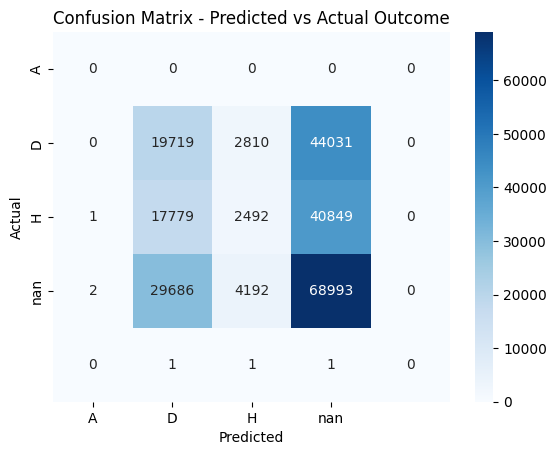


Sample of Actual vs Predicted Outcome:


,HomeTeam,AwayTeam,MatchDate,FTResult,PredictedOutcome
0,Marseille,Troyes,2000-07-28,H,H
1,Paris SG,Strasbourg,2000-07-28,H,H
2,Wasquehal,Nancy,2000-07-28,A,A
3,Auxerre,Sedan,2000-07-29,A,H
4,Bordeaux,Metz,2000-07-29,D,A


In [21]:
# Compare predicted outcome against FTResult if available

if 'FTResult' in predicted_matches_df.columns and 'PredictedOutcome' in predicted_matches_df.columns:
    print("\n--- Comparing Predicted Outcome to Actual FTResult ---")

    # Ensure 'FTResult' is treated as string for comparison
    predicted_matches_df['FTResult_str'] = predicted_matches_df['FTResult'].astype(str).fillna('Unknown')

    # Filter out rows where actual FTResult is 'Unknown' if you don't want to compare them
    comparison_outcome_df = predicted_matches_df[predicted_matches_df['FTResult_str'] != 'Unknown'].copy()

    if not comparison_outcome_df.empty:
        # Calculate accuracy
        accuracy = accuracy_score(comparison_outcome_df['FTResult_str'], comparison_outcome_df['PredictedOutcome'])
        print(f"Accuracy of Predicted Outcome vs Actual FTResult: {accuracy:.4f}")

        # Display classification report
        print("\nClassification Report:")
        print(classification_report(comparison_outcome_df['FTResult_str'], comparison_outcome_df['PredictedOutcome']))

        # Display confusion matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(comparison_outcome_df['FTResult_str'], comparison_outcome_df['PredictedOutcome'])
        # Ensure class labels are in a consistent order for the confusion matrix
        labels = sorted(comparison_outcome_df['FTResult_str'].unique())
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Predicted vs Actual Outcome')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Display a sample of the comparison
        print("\nSample of Actual vs Predicted Outcome:")
        display(comparison_outcome_df[['HomeTeam', 'AwayTeam', 'MatchDate', 'FTResult', 'PredictedOutcome']].head())

    else:
        print("No valid rows for outcome comparison after handling missing actual FTResult.")

elif 'FTResult' not in predicted_matches_df.columns:
    print("\nActual 'FTResult' column not found in the new matches data. Cannot compare predicted outcome to actual outcomes.")

elif 'PredictedOutcome' not in predicted_matches_df.columns:
     print("\n'PredictedOutcome' column not found. Please ensure match outcomes were predicted successfully.")

In [22]:
# Combine and display predicted outcomes and predicted total goals

# Ensure both prediction columns exist in the DataFrame
if 'PredictedOutcome' in predicted_matches_df.columns and 'PredictedTotalGoals' in predicted_matches_df.columns:
    print("\n--- Combined Predictions for New Matches ---")

    # Display key information along with both predictions, including actual FTResult and TotalGoals
    display(predicted_matches_df[[
        'MatchDate', 'HomeTeam', 'AwayTeam',
        'FTResult', 'TotalGoals', # Include actual columns
        'PredictedOutcome', 'PredictedTotalGoals'
    ]].head())

    # You could also save this combined DataFrame to a new CSV file
    predicted_matches_df.to_csv('new_matches_with_predictions.csv', index=False)
    print("\nCombined predictions saved to 'new_matches_with_predictions.csv'")

else:
    print("Predicted outcome or predicted total goals columns not found in the DataFrame.")
    print("Please ensure both predictions were generated successfully in the previous steps.")


--- Combined Predictions for New Matches ---


,MatchDate,HomeTeam,AwayTeam,FTResult,TotalGoals,PredictedOutcome,PredictedTotalGoals
0,2000-07-28,Marseille,Troyes,H,4.0,H,2.651290
1,2000-07-28,Paris SG,Strasbourg,H,4.0,H,2.918759
2,2000-07-28,Wasquehal,Nancy,A,1.0,A,2.395655
3,2000-07-29,Auxerre,Sedan,A,1.0,H,2.341913
4,2000-07-29,Bordeaux,Metz,D,2.0,A,2.424750



Combined predictions saved to 'new_matches_with_predictions.csv'


In [23]:
# Save the combined predictions to a CSV file
if 'predicted_matches_df' in globals():
    predicted_matches_df.to_csv('new_matches_with_predictions.csv', index=False)
    print("Combined predictions saved to 'new_matches_with_predictions.csv'")
else:
    print("The DataFrame 'predicted_matches_df' was not found. Please ensure predictions were generated successfully.")

Combined predictions saved to 'new_matches_with_predictions.csv'


In [24]:
import joblib

# Save the best performing outcome prediction model
if 'model_trainer' in globals() and hasattr(model_trainer, 'best_outcome_model'):
    best_outcome_model_name = model_trainer.best_outcome_model[0]
    best_outcome_model_obj = model_trainer.best_outcome_model[1]['model']
    outcome_model_filename = f'{best_outcome_model_name.replace(" ", "_")}_outcome_model.joblib'
    joblib.dump(best_outcome_model_obj, outcome_model_filename)
    print(f"Best outcome model saved as: {outcome_model_filename}")
else:
    print("Best outcome model not found. Please ensure training was successful.")

# Save the best performing goals prediction model
if 'model_trainer' in globals() and hasattr(model_trainer, 'best_goals_model'):
    best_goals_model_name = model_trainer.best_goals_model[0]
    best_goals_model_obj = model_trainer.best_goals_model[1]['model']
    goals_model_filename = f'{best_goals_model_name.replace(" ", "_")}_goals_model.joblib'
    joblib.dump(best_goals_model_obj, goals_model_filename)
    print(f"Best goals model saved as: {goals_model_filename}")
else:
    print("Best goals model not found. Please ensure training was successful.")

# If StandardScaler was used for outcome model, save it as well
if 'model_trainer' in globals() and 'outcome' in model_trainer.scalers:
    outcome_scaler_filename = 'outcome_scaler.joblib'
    joblib.dump(model_trainer.scalers['outcome'], outcome_scaler_filename)
    print(f"Outcome scaler saved as: {outcome_scaler_filename}")

# If StandardScaler was used for goals model, save it as well
if 'model_trainer' in globals() and 'goals' in model_trainer.scalers:
    goals_scaler_filename = 'goals_scaler.joblib'
    joblib.dump(model_trainer.scalers['goals'], goals_scaler_filename)
    print(f"Goals scaler saved as: {goals_scaler_filename}")

Best outcome model saved as: Gradient_Boosting_Classifier_outcome_model.joblib
Best goals model saved as: XGBoost_Regressor_goals_model.joblib
Outcome scaler saved as: outcome_scaler.joblib
Goals scaler saved as: goals_scaler.joblib


In [ ]:
# This is an outline of a Python script to make predictions using the saved models

import pandas as pd
import numpy as np
import joblib
import sys

# Assume the saved files are in the same directory as this script
# Update the filenames if they are located elsewhere
OUTCOME_MODEL_FILENAME = 'Gradient_Boosting_Classifier_outcome_model.joblib'
GOALS_MODEL_FILENAME = 'XGBoost_Regressor_goals_model.joblib'
OUTCOME_SCALER_FILENAME = 'outcome_scaler.joblib'
GOALS_SCALER_FILENAME = 'goals_scaler.joblib'

# --- Load Saved Models and Scalers ---
try:
    best_outcome_model = joblib.load(OUTCOME_MODEL_FILENAME)
    best_goals_model = joblib.load(GOALS_MODEL_FILENAME)
    outcome_scaler = joblib.load(OUTCOME_SCALER_FILENAME)
    goals_scaler = joblib.load(GOALS_SCALER_FILENAME)
    print("Models and scalers loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading saved files: {e}")
    print("Please ensure the .joblib files are in the same directory as the script.")
    sys.exit(1) # Exit if files are not found

# --- Define the Preprocessing Steps ---
# This should replicate the preprocessing and feature engineering done in the notebook
# You might need to adapt the FootballPredictor class or extract the relevant functions
# For simplicity, let's assume you have functions for cleaning and feature creation
# You would need to define these functions based on your notebook code

def clean_new_data(df):
    """Clean new data based on the steps in the notebook."""
    # Implement the cleaning steps from your FootballPredictor.clean_data method
    # Example: handle infinite values, clean betting odds, Elo, form, etc.
    df = df.replace([np.inf, -np.inf], np.nan)
    # Add other cleaning logic here...
    df = df.fillna(0) # Simple fill for demonstration
    return df

def create_new_features(df):
    """Create features for new data based on the steps in the notebook."""
    # Implement the feature creation steps from your FootballPredictor.create_features method
    # Ensure the new feature columns match the training feature columns exactly
    df['EloDiff'] = df['HomeElo'] - df['AwayElo']
    df['EloSum'] = df['HomeElo'] + df['AwayElo']
    # Add other feature engineering logic here...
    return df

def preprocess_new_data(df, feature_columns):
    """Complete preprocessing for new data."""
    df = clean_new_data(df.copy())
    df = create_new_features(df)

    # Select only the feature columns used during training
    # Ensure the order of columns matches the training data
    try:
        processed_features = df[feature_columns]
    except KeyError as e:
        print(f"Error: Missing feature column in new data: {e}")
        print("Please ensure the new data contains all required columns.")
        sys.exit(1)

    # Apply scalers
    processed_features_scaled_outcome = outcome_scaler.transform(processed_features)
    processed_features_scaled_goals = goals_scaler.transform(processed_features) # Use appropriate scaler

    return processed_features, processed_features_scaled_outcome, processed_features_scaled_goals


# --- Define the Prediction Function ---
def make_predictions(new_data_df):
    """
    Makes match outcome and total goals predictions on new data.

    Args:
        new_data_df (pd.DataFrame): DataFrame containing the new match data.

    Returns:
        pd.DataFrame: DataFrame with original data and added prediction columns.
    """
    # Define the feature columns - these must be the same as used during training
    # You would get this list from your notebook after feature engineering
    # For demonstration, using a placeholder list
    feature_columns = ['HomeElo', 'AwayElo', 'EloDiff', 'EloSum', 'Form3Home', 'Form5Home',
                       'Form3Away', 'Form5Away', 'Form3Ratio', 'Form5Ratio',
                       'HomeExpectedGoals', 'AwayExpectedGoals', 'HomeWinProbability',
                       'DrawProbability', 'AwayWinProbability', 'HomeShotEfficiency',
                       'AwayShotEfficiency', 'HomeAttackStrength', 'AwayAttackStrength',
                       'HandiSize', 'Over25', 'Under25', 'C_LTH', 'C_LTA', 'C_VHD',
                       'C_VAD', 'C_HTB', 'C_PHB'] # Replace with your actual feature columns

    # Preprocess the new data
    processed_features, processed_features_scaled_outcome, processed_features_scaled_goals = preprocess_new_data(new_data_df.copy(), feature_columns)

    # Make outcome predictions
    # Check which model was the best outcome model and use the correct scaled/unscaled features
    if isinstance(best_outcome_model, LogisticRegression): # Check the type of the loaded model
         outcome_predictions_encoded = best_outcome_model.predict(processed_features_scaled_outcome)
    else:
         outcome_predictions_encoded = best_outcome_model.predict(processed_features)

    # Decode outcome predictions (you'll need the label encoder from the notebook)
    # For this script outline, we'll just return the encoded predictions
    # In a real script, you would save and load the label_encoder as well
    # outcome_predictions = label_encoder.inverse_transform(outcome_predictions_encoded)
    outcome_predictions_decoded = outcome_predictions_encoded # Placeholder

    # Make total goals predictions
    # Check which model was the best goals model and use the correct scaled/unscaled features
    # Assuming XGBoost Regressor (best in notebook) doesn't require scaled features
    # If your best goals model required scaling, use processed_features_scaled_goals
    goals_predictions = best_goals_model.predict(processed_features)


    # Add predictions to the original DataFrame
    new_data_df['PredictedOutcome_encoded'] = outcome_predictions_encoded
    new_data_df['PredictedOutcome'] = outcome_predictions_decoded # Replace with decoded if label_encoder is loaded
    new_data_df['PredictedTotalGoals'] = goals_predictions

    return new_data_df

# --- Example Usage ---
if __name__ == "__main__":
    # Load new data (replace with your method of loading new data)
    # Example: Load from a CSV file
    try:
        # Replace 'path/to/your/new_matches_data.csv' with the actual path
        new_matches_data = pd.read_csv('Matches.csv', low_memory=False)
        print(f"\nLoaded new data with shape: {new_matches_data.shape}")
    except FileNotFoundError:
        print("Error: New matches data file not found.")
        sys.exit(1)

    # Make predictions
    predictions_df = make_predictions(new_matches_data)

    # Display predictions
    print("\nPredictions for New Matches:")
    print(predictions_df[['MatchDate', 'HomeTeam', 'AwayTeam', 'PredictedOutcome', 'PredictedTotalGoals']].head())

    # Optional: Save predictions to a new CSV
    # predictions_df.to_csv('new_matches_predictions_output.csv', index=False)
    # print("\nPredictions saved to 'new_matches_predictions_output.csv'")


In [26]:
# You would need to save and load the label_encoder as well to decode predictions
# Example of saving the label_encoder in your notebook after fitting:
import joblib
joblib.dump(label_encoder, 'label_encoder.joblib')

# Example of loading the label_encoder in your prediction script:
# label_encoder = joblib.load('label_encoder.joblib')
# Then use: outcome_predictions = label_encoder.inverse_transform(outcome_predictions_encoded)


['label_encoder.joblib']

In [ ]:
# This is an outline for a Streamlit application (save as a .py file)

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import sys # For exiting if files not found

# Assume models and scalers are in the same directory
OUTCOME_MODEL_FILENAME = 'Gradient_Boosting_Classifier_outcome_model.joblib'
GOALS_MODEL_FILENAME = 'XGBoost_Regressor_goals_model.joblib'
OUTCOME_SCALER_FILENAME = 'outcome_scaler.joblib'
GOALS_SCALER_FILENAME = 'goals_scaler.joblib'
LABEL_ENCODER_FILENAME = 'label_encoder.joblib' # You would need to save your label encoder

# --- Load Saved Models, Scalers, and Label Encoder ---
@st.cache_resource # Cache resources for efficiency
def load_resources():
    """Loads the saved models, scalers, and label encoder."""
    try:
        outcome_model = joblib.load(OUTCOME_MODEL_FILENAME)
        goals_model = joblib.load(GOALS_MODEL_FILENAME)
        outcome_scaler = joblib.load(OUTCOME_SCALER_FILENAME)
        goals_scaler = joblib.load(GOALS_SCALER_FILENAME)
        # Load label encoder as well if you saved it
        # label_encoder = joblib.load(LABEL_ENCODER_FILENAME)
        # return outcome_model, goals_model, outcome_scaler, goals_scaler, label_encoder
        return outcome_model, goals_model, outcome_scaler, goals_scaler # Return without label encoder for now
    except FileNotFoundError as e:
        st.error(f"Error loading saved files: {e}")
        st.error("Please ensure the .joblib files are in the same directory as the script.")
        return None, None, None, None #, None


outcome_model, goals_model, outcome_scaler, goals_scaler = load_resources() #, label_encoder


# --- Define the Preprocessing and Feature Engineering Steps ---
# These functions should replicate the steps from your notebook and script outline
# You will need to copy and paste the logic from your FootballPredictor class methods
# or the preprocess_new_data function here.

def clean_input_data(df):
    """Clean input data based on the steps in the notebook."""
    # Implement the cleaning steps (handle NaNs, infinities, extreme values)
    df = df.replace([np.inf, -np.inf], np.nan)
    # Add your cleaning logic here...
    df = df.fillna(0) # Simple fill for demonstration
    return df

def create_input_features(df):
    """Create features for input data based on the steps in the notebook."""
    # Implement your feature engineering logic here (EloDiff, FormRatio, etc.)
    # Note: Some features like HomeExpectedGoals/AwayExpectedGoals and Form Ratios might
    # require historical data lookups or calculations that are complex for a simple app.
    # For this outline, we'll assume simple calculations or direct input for all features.
    if 'HomeElo' in df.columns and 'AwayElo' in df.columns:
      df['EloDiff'] = df['HomeElo'] - df['AwayElo']
      df['EloSum'] = df['HomeElo'] + df['AwayElo']
    else:
      df['EloDiff'] = 0.0
      df['EloSum'] = 0.0


    # Assuming Form Ratios are directly input or simplified
    if 'Form3Home' in df.columns and 'Form3Away' in df.columns and df['Form3Away'].iloc[0] > 0:
        df['Form3Ratio'] = df['Form3Home'] / df['Form3Away']
    else:
        df['Form3Ratio'] = df['Form3Home'] / 0.1 # Avoid division by zero

    if 'Form5Home' in df.columns and 'Form5Away' in df.columns and df['Form5Away'].iloc[0] > 0:
        df['Form5Ratio'] = df['Form5Home'] / df['Form5Away']
    else:
        df['Form5Ratio'] = df['Form5Home'] / 0.1 # Avoid division by zero

    # Assuming Expected Goals are directly input or simplified
    if 'HomeExpectedGoals' not in df.columns:
        df['HomeExpectedGoals'] = 1.5 # Default or calculated differently
    if 'AwayExpectedGoals' not in df.columns:
        df['AwayExpectedGoals'] = 1.2 # Default or calculated differently

    # Assuming betting probabilities are directly input or simplified
    if 'OddHome' in df.columns and df['OddHome'].iloc[0] > 1:
        df['HomeWinProbability'] = 1 / df['OddHome']
    else:
        df['HomeWinProbability'] = 0.0

    if 'OddDraw' in df.columns and df['OddDraw'].iloc[0] > 1:
        df['DrawProbability'] = 1 / df['OddDraw']
    else:
        df['DrawProbability'] = 0.0

    if 'OddAway' in df.columns and df['OddAway'].iloc[0] > 1:
        df['AwayWinProbability'] = 1 / df['OddAway']
    else:
        df['AwayWinProbability'] = 0.0

    # Assuming shot efficiencies are directly input or simplified
    if 'HomeTarget' in df.columns and 'HomeShots' in df.columns and df['HomeShots'].iloc[0] > 0:
        df['HomeShotEfficiency'] = df['HomeTarget'] / df['HomeShots']
    else:
        df['HomeShotEfficiency'] = 0.0

    if 'AwayTarget' in df.columns and 'AwayShots' in df.columns and df['AwayShots'].iloc[0] > 0:
        df['AwayShotEfficiency'] = df['AwayTarget'] / df['AwayShots']
    else:
        df['AwayShotEfficiency'] = 0.0

    # Assuming attack strength is directly input or simplified
    if 'HomeExpectedGoals' in df.columns and 'Form5Home' in df.columns:
        df['HomeAttackStrength'] = df['HomeExpectedGoals'] * df['Form5Home'] / 15
    else:
        df['HomeAttackStrength'] = 0.0

    if 'AwayExpectedGoals' in df.columns and 'Form5Away' in df.columns:
        df['AwayAttackStrength'] = df['AwayExpectedGoals'] * df['Form5Away'] / 15
    else:
        df['AwayAttackStrength'] = 0.0

    return df

def preprocess_input_data(input_df, outcome_scaler, goals_scaler, feature_columns):
    """Complete preprocessing for input data."""
    # Ensure the input DataFrame has all necessary columns, even if with default values
    # based on the feature_columns list.
    for col in feature_columns:
        if col not in input_df.columns:
            input_df[col] = 0.0 # Add missing feature columns with a default value

    cleaned_df = clean_input_data(input_df.copy())
    # Recreate features after ensuring all columns are present
    featured_df = create_input_features(cleaned_df)

    # Select and reorder features to match training data
    try:
        processed_features = featured_df[feature_columns]
    except KeyError as e:
        st.error(f"Error: Missing required column after feature creation: {e}")
        return None, None, None # Return None for all outputs on error


    # Apply scalers
    # Ensure processed_features is a DataFrame with correct column order for scaling
    processed_features_scaled_outcome = outcome_scaler.transform(processed_features)
    processed_features_scaled_goals = goals_scaler.transform(processed_features)

    return processed_features_scaled_outcome, scaled_goals_features, processed_features # Return original features as well


# Define the feature columns - MUST MATCH the list used during training
# Get this list accurately from your notebook's feature engineering step
feature_columns = ['HomeElo', 'AwayElo', 'EloDiff', 'EloSum', 'Form3Home', 'Form5Home',
                   'Form3Away', 'Form5Away', 'Form3Ratio', 'Form5Ratio',
                   'HomeExpectedGoals', 'AwayExpectedGoals', 'HomeWinProbability',
                   'DrawProbability', 'AwayWinProbability', 'HomeShotEfficiency',
                   'AwayShotEfficiency', 'HomeAttackStrength', 'AwayAttackStrength',
                   'HandiSize', 'Over25', 'Under25', 'C_LTH', 'C_LTA', 'C_VHD',
                   'C_VAD', 'C_HTB', 'C_PHB'] # Replace with your actual feature columns


# --- Streamlit App Layout and Logic ---
st.title("Football Match Predictor")

if outcome_model is not None and goals_model is not None and outcome_scaler is not None and goals_scaler is not None:
    st.sidebar.header("Match Details")

    # Add input fields for match details in the sidebar for ALL features
    input_values = {}
    input_values['HomeTeam'] = st.sidebar.text_input("Home Team", "Team A")
    input_values['AwayTeam'] = st.sidebar.text_input("Away Team", "Team B")

    st.sidebar.subheader("Match Statistics and Ratings")

    # Dictionary to hold input values for each feature
    feature_input_values = {}

    for col in feature_columns:
        # Determine appropriate input type and default value based on feature name/type
        # Provide reasonable default values and labels following the requested format
        label = col
        default_value = 0.0
        step_size = 0.01
        min_value = None
        max_value = None

        if col == 'HomeElo':
            label = "Home Elo Rating"
            default_value = 1500.0
            step_size = 0.1
        elif col == 'AwayElo':
            label = "Away Elo Rating"
            default_value = 1500.0
            step_size = 0.1
        elif col == 'EloDiff':
            label = "Elo Difference (Home - Away)"
            default_value = 0.0
            step_size = 0.1
        elif col == 'EloSum':
            label = "Elo Sum (Home + Away)"
            default_value = 3000.0
            step_size = 0.1
        elif col == 'Form3Home':
            label = "Home Form (last 3)"
            default_value = 0
            min_value = 0
            max_value = 9
            step_size = 1
        elif col == 'Form5Home':
            label = "Home Form (last 5)"
            default_value = 0
            min_value = 0
            max_value = 15
            step_size = 1
        elif col == 'Form3Away':
            label = "Away Form (last 3)"
            default_value = 0
            min_value = 0
            max_value = 9
            step_size = 1
        elif col == 'Form5Away':
            label = "Away Form (last 5)"
            default_value = 0
            min_value = 0
            max_value = 15
            step_size = 1
        elif col == 'Form3Ratio':
            label = "Form 3 Ratio (Home / Away)"
            default_value = 1.0
            step_size = 0.01
            min_value = 0.1
            max_value = 10.0
        elif col == 'Form5Ratio':
            label = "Form 5 Ratio (Home / Away)"
            default_value = 1.0
            step_size = 0.01
            min_value = 0.1
            max_value = 10.0
        elif 'ExpectedGoals' in col:
             label = col.replace('ExpectedGoals', ' Expected Goals')
             default_value = 1.5
             step_size = 0.01
        elif 'WinProbability' in col:
             label = col.replace('WinProbability', ' Win Probability')
             default_value = 0.33
             step_size = 0.001
             min_value = 0.0
             max_value = 1.0
        elif 'DrawProbability' in col:
             label = "Draw Probability"
             default_value = 0.33
             step_size = 0.001
             min_value = 0.0
             max_value = 1.0
        elif 'ShotEfficiency' in col:
             label = col.replace('ShotEfficiency', ' Shot Efficiency')
             default_value = 0.5
             step_size = 0.01
             min_value = 0.0
             max_value = 1.0
        elif 'AttackStrength' in col:
             label = col.replace('AttackStrength', ' Attack Strength')
             default_value = 0.0
             step_size = 0.1
             min_value = 0.0
             max_value = 5.0
        elif col == 'HandiSize':
             label = "Handicap Size"
             default_value = 0.0
             step_size = 0.1
        elif col == 'Over25':
             label = "Over 2.5 Odds"
             default_value = 0.0 # Or a typical odd value
             step_size = 0.01
        elif col == 'Under25':
             label = "Under 2.5 Odds"
             default_value = 0.0 # Or a typical odd value
             step_size = 0.01
        elif col in ['C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']:
             label = f"Cluster Feature: {col}"
             default_value = 0.0
             step_size = 0.001
             min_value = 0.0 # Assuming these are ratios/probabilities bounded between 0 and 1
             max_value = 1.0

        # Create the number input widget
        feature_input_values[col] = st.sidebar.number_input(
            label=label,
            value=default_value,
            step=step_size,
            min_value=min_value,
            max_value=max_value
        )

    # Combine team names and feature values into a single dictionary
    input_data = {'HomeTeam': input_values['HomeTeam'], 'AwayTeam': input_values['AwayTeam']}
    input_data.update(feature_input_values)

    # Create a DataFrame from input values
    input_df_raw = pd.DataFrame([input_data])

    # Add placeholder values for columns required by feature engineering but not input by user
    # Example: FTHome and FTAway might be needed for expected goals calculation
    # If your feature engineering relies on these, you might need to simplify it for a live app
    # or provide these values differently. For this outline, we'll add them with default 0.
    # Ensure these columns are added before calling create_input_features
    required_for_feature_eng = ['FTHome', 'FTAway', 'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget',
                                'OddHome', 'OddDraw', 'OddAway'] # Add other required columns
    for col in required_for_feature_eng:
        if col not in input_df_raw.columns:
            # Add with a default value that makes sense for the feature engineering calculation
            if 'Odd' in col:
                 input_df_raw[col] = 1.0 # Betting odds are usually >= 1
            else:
                 input_df_raw[col] = 0.0

    # Ensure the order of columns in the raw input DataFrame matches the expected order
    # This might involve reordering or adding missing columns with default values
    # A robust app would handle this carefully.

    if st.sidebar.button("Predict"):
        # Preprocess the input data
        # Pass the raw input DataFrame with added placeholder columns
        scaled_outcome_features, scaled_goals_features, original_features = preprocess_input_data(
            input_df_raw, outcome_scaler, goals_scaler, feature_columns
        )

        if scaled_outcome_features is not None and original_features is not None:
            # Make predictions
            # Check which model was the best outcome model and use the correct scaled/unscaled features
            if isinstance(outcome_model, LogisticRegression): # Check the type of the loaded model
                 outcome_prediction_encoded = outcome_model.predict(scaled_outcome_features)
            else:
                 # Use original features if your model doesn't need scaling
                 # Ensure original_features has the correct columns and order
                 outcome_prediction_encoded = outcome_model.predict(original_features[feature_columns])


            # Check which model was the best goals model and use the correct scaled/unscaled features
            # Assuming XGBoost Regressor (best in notebook) doesn't require scaled features
            # If your best goals model required scaling, use scaled_goals_features
            goals_prediction = goals_model.predict(original_features[feature_columns])


            # Decode outcome prediction (if you loaded label_encoder)
            # You would need to save and load the label_encoder
            # predicted_outcome = label_encoder.inverse_transform(outcome_prediction_encoded)
            # For now, display the encoded prediction
            predicted_outcome_display = outcome_prediction_encoded[0]

            st.subheader("Prediction Results:")
            st.write(f"Predicted Match Outcome (Encoded): {predicted_outcome_display}")
            # If you loaded label_encoder, use the decoded outcome:
            # st.write(f"Predicted Match Outcome: {predicted_outcome[0]}")
            st.write(f"Predicted Total Goals: {goals_prediction[0]:.2f}")

else:
    st.warning("Models or scalers could not be loaded. Please check the file paths and ensure they are in the same directory as the script.")


In [ ]:
# This is an outline for a Streamlit application (save as a .py file)

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import sys # For exiting if files not found

# Assume models and scalers are in the same directory
OUTCOME_MODEL_FILENAME = 'Gradient_Boosting_Classifier_outcome_model.joblib'
GOALS_MODEL_FILENAME = 'XGBoost_Regressor_goals_model.joblib'
OUTCOME_SCALER_FILENAME = 'outcome_scaler.joblib'
GOALS_SCALER_FILENAME = 'goals_scaler.joblib'
LABEL_ENCODER_FILENAME = 'label_encoder.joblib' # You would need to save your label encoder

# --- Load Saved Models, Scalers, and Label Encoder ---
@st.cache_resource # Cache resources for efficiency
def load_resources():
    """Loads the saved models, scalers, and label encoder."""
    try:
        outcome_model = joblib.load(OUTCOME_MODEL_FILENAME)
        goals_model = joblib.load(GOALS_MODEL_FILENAME)
        outcome_scaler = joblib.load(OUTCOME_SCALER_FILENAME)
        goals_scaler = joblib.load(GOALS_SCALER_FILENAME)
        # Load label encoder as well if you saved it
        # label_encoder = joblib.load(LABEL_ENCODER_FILENAME)
        # return outcome_model, goals_model, outcome_scaler, goals_scaler, label_encoder
        return outcome_model, goals_model, outcome_scaler, goals_scaler # Return without label encoder for now
    except FileNotFoundError as e:
        st.error(f"Error loading saved files: {e}")
        st.error("Please ensure the .joblib files are in the same directory as the script.")
        return None, None, None, None #, None


outcome_model, goals_model, outcome_scaler, goals_scaler = load_resources() #, label_encoder


# --- Define the Preprocessing and Feature Engineering Steps ---
# These functions should replicate the steps from your notebook and script outline
# You will need to copy and paste the logic from your FootballPredictor class methods
# or the preprocess_new_data function here.

def clean_input_data(df):
    """Clean input data based on the steps in the notebook."""
    # Implement the cleaning steps (handle NaNs, infinities, extreme values)
    df = df.replace([np.inf, -np.inf], np.nan)
    # Add your cleaning logic here...
    df = df.fillna(0) # Simple fill for demonstration
    return df

def create_input_features(df):
    """Create features for input data based on the steps in the notebook."""
    # Implement your feature engineering logic here (EloDiff, FormRatio, etc.)
    # Note: Some features like HomeExpectedGoals/AwayExpectedGoals and Form Ratios might
    # require historical data lookups or calculations that are complex for a simple app.
    # For this outline, we'll assume simple calculations or direct input for all features.
    if 'HomeElo' in df.columns and 'AwayElo' in df.columns:
      df['EloDiff'] = df['HomeElo'] - df['AwayElo']
      df['EloSum'] = df['HomeElo'] + df['AwayElo']
    else:
      df['EloDiff'] = 0.0
      df['EloSum'] = 0.0


    # Assuming Form Ratios are directly input or simplified
    if 'Form3Home' in df.columns and 'Form3Away' in df.columns and df['Form3Away'].iloc[0] > 0:
        df['Form3Ratio'] = df['Form3Home'] / df['Form3Away']
    else:
        df['Form3Ratio'] = df['Form3Home'] / 0.1 # Avoid division by zero

    if 'Form5Home' in df.columns and 'Form5Away' in df.columns and df['Form5Away'].iloc[0] > 0:
        df['Form5Ratio'] = df['Form5Home'] / df['Form5Away']
    else:
        df['Form5Ratio'] = df['Form5Home'] / 0.1 # Avoid division by zero

    # Assuming Expected Goals are directly input or simplified
    if 'HomeExpectedGoals' not in df.columns:
        df['HomeExpectedGoals'] = 1.5 # Default or calculated differently
    if 'AwayExpectedGoals' not in df.columns:
        df['AwayExpectedGoals'] = 1.2 # Default or calculated differently

    # Assuming betting probabilities are directly input or simplified
    if 'OddHome' in df.columns and df['OddHome'].iloc[0] > 1:
        df['HomeWinProbability'] = 1 / df['OddHome']
    else:
        df['HomeWinProbability'] = 0.0

    if 'OddDraw' in df.columns and df['OddDraw'].iloc[0] > 1:
        df['DrawProbability'] = 1 / df['OddDraw']
    else:
        df['DrawProbability'] = 0.0

    if 'OddAway' in df.columns and df['OddAway'].iloc[0] > 1:
        df['AwayWinProbability'] = 1 / df['OddAway']
    else:
        df['AwayWinProbability'] = 0.0

    # Assuming shot efficiencies are directly input or simplified
    if 'HomeTarget' in df.columns and 'HomeShots' in df.columns and df['HomeShots'].iloc[0] > 0:
        df['HomeShotEfficiency'] = df['HomeTarget'] / df['HomeShots']
    else:
        df['HomeShotEfficiency'] = 0.0

    if 'AwayTarget' in df.columns and 'AwayShots' in df.columns and df['AwayShots'].iloc[0] > 0:
        df['AwayShotEfficiency'] = df['AwayTarget'] / df['AwayShots']
    else:
        df['AwayShotEfficiency'] = 0.0

    # Assuming attack strength is directly input or simplified
    if 'HomeExpectedGoals' in df.columns and 'Form5Home' in df.columns:
        df['HomeAttackStrength'] = df['HomeExpectedGoals'] * df['Form5Home'] / 15
    else:
        df['HomeAttackStrength'] = 0.0

    if 'AwayExpectedGoals' in df.columns and 'Form5Away' in df.columns:
        df['AwayAttackStrength'] = df['AwayExpectedGoals'] * df['Form5Away'] / 15
    else:
        df['AwayAttackStrength'] = 0.0

    return df

def preprocess_input_data(input_df, outcome_scaler, goals_scaler, feature_columns):
    """Complete preprocessing for input data."""
    # Ensure the input DataFrame has all necessary columns, even if with default values
    # based on the feature_columns list.
    for col in feature_columns:
        if col not in input_df.columns:
            input_df[col] = 0.0 # Add missing feature columns with a default value

    cleaned_df = clean_input_data(input_df.copy())
    # Recreate features after ensuring all columns are present
    featured_df = create_input_features(cleaned_df)

    # Select and reorder features to match training data
    try:
        processed_features = featured_df[feature_columns]
    except KeyError as e:
        st.error(f"Error: Missing required column after feature creation: {e}")
        return None, None, None # Return None for all outputs on error


    # Apply scalers
    # Ensure processed_features is a DataFrame with correct column order for scaling
    processed_features_scaled_outcome = outcome_scaler.transform(processed_features)
    processed_features_scaled_goals = goals_scaler.transform(processed_features)

    return processed_features_scaled_outcome, processed_features_scaled_goals, processed_features # Return original features as well


# Define the feature columns - MUST MATCH the list used during training
# Get this list accurately from your notebook's feature engineering step
feature_columns = ['HomeElo', 'AwayElo', 'EloDiff', 'EloSum', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'Form3Ratio', 'Form5Ratio', 'HomeExpectedGoals', 'AwayExpectedGoals', 'HomeWinProbability', 'DrawProbability', 'AwayWinProbability', 'HomeShotEfficiency', 'AwayShotEfficiency', 'HomeAttackStrength', 'AwayAttackStrength', 'HandiSize', 'Over25', 'Under25', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']


# --- Streamlit App Layout and Logic ---
st.title("Football Match Predictor")

if outcome_model is not None and goals_model is not None and outcome_scaler is not None and goals_scaler is not None:
    st.sidebar.header("Match Details")

    # Add input fields for match details in the sidebar for ALL features
    input_values = {}
    input_values['HomeTeam'] = st.sidebar.text_input("Home Team", "Team A")
    input_values['AwayTeam'] = st.sidebar.text_input("Away Team", "Team B")

    st.sidebar.subheader("Match Statistics and Ratings")

    # Dictionary to hold input values for each feature
    feature_input_values = {}

    for col in feature_columns:
        # Determine appropriate input type and default value based on feature name/type
        # Provide reasonable default values and labels following the requested format
        label = col
        default_value = 0.0
        step_size = 0.01
        min_value = None
        max_value = None

        if col == 'HomeElo':
            label = "Home Elo Rating"
            default_value = 1500.0
            step_size = 0.1
        elif col == 'AwayElo':
            label = "Away Elo Rating"
            default_value = 1500.0
            step_size = 0.1
        elif col == 'EloDiff':
            label = "Elo Difference (Home - Away)"
            default_value = 0.0
            step_size = 0.1
        elif col == 'EloSum':
            label = "Elo Sum (Home + Away)"
            default_value = 3000.0
            step_size = 0.1
        elif col == 'Form3Home':
            label = "Home Form (last 3)"
            default_value = 0
            min_value = 0
            max_value = 9
            step_size = 1
        elif col == 'Form5Home':
            label = "Home Form (last 5)"
            default_value = 0
            min_value = 0
            max_value = 15
            step_size = 1
        elif col == 'Form3Away':
            label = "Away Form (last 3)"
            default_value = 0
            min_value = 0
            max_value = 9
            step_size = 1
        elif col == 'Form5Away':
            label = "Away Form (last 5)"
            default_value = 0
            min_value = 0
            max_value = 15
            step_size = 1
        elif col == 'Form3Ratio':
            label = "Form 3 Ratio (Home / Away)"
            default_value = 1.0
            step_size = 0.01
            min_value = 0.1
            max_value = 10.0
        elif col == 'Form5Ratio':
            label = "Form 5 Ratio (Home / Away)"
            default_value = 1.0
            step_size = 0.01
            min_value = 0.1
            max_value = 10.0
        elif 'ExpectedGoals' in col:
             label = col.replace('ExpectedGoals', ' Expected Goals')
             default_value = 1.5
             step_size = 0.01
        elif 'WinProbability' in col:
             label = col.replace('WinProbability', ' Win Probability')
             default_value = 0.33
             step_size = 0.001
             min_value = 0.0
             max_value = 1.0
        elif 'DrawProbability' in col:
             label = "Draw Probability"
             default_value = 0.33
             step_size = 0.001
             min_value = 0.0
             max_value = 1.0
        elif 'ShotEfficiency' in col:
             label = col.replace('ShotEfficiency', ' Shot Efficiency')
             default_value = 0.5
             step_size = 0.01
             min_value = 0.0
             max_value = 1.0
        elif 'AttackStrength' in col:
             label = col.replace('AttackStrength', ' Attack Strength')
             default_value = 0.0
             step_size = 0.1
             min_value = 0.0
             max_value = 5.0
        elif col == 'HandiSize':
             label = "Handicap Size"
             default_value = 0.0
             step_size = 0.1
        elif col == 'Over25':
             label = "Over 2.5 Odds"
             default_value = 0.0 # Or a typical odd value
             step_size = 0.01
        elif col == 'Under25':
             label = "Under 2.5 Odds"
             default_value = 0.0 # Or a typical odd value
             step_size = 0.01
        elif col in ['C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']:
             label = f"Cluster Feature: {col}"
             default_value = 0.0
             step_size = 0.001
             min_value = 0.0 # Assuming these are ratios/probabilities bounded between 0 and 1
             max_value = 1.0

        # Create the number input widget
        feature_input_values[col] = st.sidebar.number_input(
            label=label,
            value=default_value,
            step=step_size,
            min_value=min_value,
            max_value=max_value
        )

    # Combine team names and feature values into a single dictionary
    input_data = {'HomeTeam': input_values['HomeTeam'], 'AwayTeam': input_values['AwayTeam']}
    input_data.update(feature_input_values)

    # Create a DataFrame from input values
    input_df_raw = pd.DataFrame([input_data])

    # Add placeholder values for columns required by feature engineering but not input by user
    # Example: FTHome and FTAway might be needed for expected goals calculation
    # If your feature engineering relies on these, you might need to simplify it for a live app
    # or provide these values differently. For this outline, we'll add them with default 0.
    # Ensure these columns are added before calling create_input_features
    required_for_feature_eng = ['FTHome', 'FTAway', 'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget',
                                'OddHome', 'OddDraw', 'OddAway'] # Add other required columns
    for col in required_for_feature_eng:
        if col not in input_df_raw.columns:
            # Add with a default value that makes sense for the feature engineering calculation
            if 'Odd' in col:
                 input_df_raw[col] = 1.0 # Betting odds are usually >= 1
            else:
                 input_df_raw[col] = 0.0

    # Ensure the order of columns in the raw input DataFrame matches the expected order
    # This might involve reordering or adding missing columns with default values
    # A robust app would handle this carefully.

    if st.sidebar.button("Predict"):
        # Preprocess the input data
        # Pass the raw input DataFrame with added placeholder columns
        scaled_outcome_features, scaled_goals_features, original_features = preprocess_input_data(
            input_df_raw, outcome_scaler, goals_scaler, feature_columns
        )

        if scaled_outcome_features is not None and original_features is not None:
            # Make predictions
            # Check which model was the best outcome model and use the correct scaled/unscaled features
            if isinstance(outcome_model, LogisticRegression): # Check the type of the loaded model
                 outcome_prediction_encoded = outcome_model.predict(scaled_outcome_features)
            else:
                 # Use original features if your model doesn't need scaling
                 # Ensure original_features has the correct columns and order
                 outcome_prediction_encoded = outcome_model.predict(original_features[feature_columns])


            # Check which model was the best goals model and use the correct scaled/unscaled features
            # Assuming XGBoost Regressor (best in notebook) doesn't require scaled features
            # If your best goals model required scaling, use scaled_goals_features
            goals_prediction = goals_model.predict(original_features[feature_columns])


            # Decode outcome prediction (if you loaded label_encoder)
            # You would need to save and load the label_encoder
            # predicted_outcome = label_encoder.inverse_transform(outcome_prediction_encoded)
            # For now, display the encoded prediction
            predicted_outcome_display = outcome_prediction_encoded[0]

            st.subheader("Prediction Results:")
            st.write(f"Predicted Match Outcome (Encoded): {predicted_outcome_display}")
            # If you loaded label_encoder, use the decoded outcome:
            # st.write(f"Predicted Match Outcome: {predicted_outcome[0]}")
            st.write(f"Predicted Total Goals: {goals_prediction[0]:.2f}")

else:
    st.warning("Models or scalers could not be loaded. Please check the file paths and ensure they are in the same directory as the script.")

Here are the features used in your model, which you will need to provide input fields for in your Streamlit app:

- HomeElo
- AwayElo
- EloDiff
- EloSum
- Form3Home
- Form5Home
- Form3Away
- Form5Away
- Form3Ratio
- Form5Ratio
- HomeExpectedGoals
- AwayExpectedGoals
- HomeWinProbability
- DrawProbability
- AwayWinProbability
- HomeShotEfficiency
- AwayShotEfficiency
- HomeAttackStrength
- AwayAttackStrength
- HandiSize
- Over25
- Under25
- C_LTH
- C_LTA
- C_VHD
- C_VAD
- C_HTB
- C_PHB

You will need to create appropriate input widgets (e.g., `st.number_input`, `st.text_input`) in your Streamlit app's sidebar or main area for each of these features to allow users to input the match details.


In [ ]:
import joblib

# Save the best performing outcome prediction model
if 'model_trainer' in globals() and hasattr(model_trainer, 'best_outcome_model'):
    best_outcome_model_name = model_trainer.best_outcome_model[0]
    best_outcome_model_obj = model_trainer.best_outcome_model[1]['model']
    outcome_model_filename = f'{best_outcome_model_name.replace(" ", "_")}_outcome_model.joblib'
    joblib.dump(best_outcome_model_obj, outcome_model_filename)
    print(f"Best outcome model saved as: {outcome_model_filename}")
else:
    print("Best outcome model not found. Please ensure training was successful.")

# Save the best performing goals prediction model
if 'model_trainer' in globals() and hasattr(model_trainer, 'best_goals_model'):
    best_goals_model_name = model_trainer.best_goals_model[0]
    best_goals_model_obj = model_trainer.best_goals_model[1]['model']
    goals_model_filename = f'{best_goals_model_name.replace(" ", "_")}_goals_model.joblib'
    joblib.dump(best_goals_model_obj, goals_model_filename)
    print(f"Best goals model saved as: {goals_model_filename}")
else:
    print("Best goals model not found. Please ensure training was successful.")

# If StandardScaler was used for outcome model, save it as well
if 'model_trainer' in globals() and 'outcome' in model_trainer.scalers:
    outcome_scaler_filename = 'outcome_scaler.joblib'
    joblib.dump(model_trainer.scalers['outcome'], outcome_scaler_filename)
    print(f"Outcome scaler saved as: {outcome_scaler_filename}")

# If StandardScaler was used for goals model, save it as well
if 'model_trainer' in globals() and 'goals' in model_trainer.scalers:
    goals_scaler_filename = 'goals_scaler.joblib'
    joblib.dump(model_trainer.scalers['goals'], goals_scaler_filename)
    print(f"Goals scaler saved as: {goals_scaler_filename}")

Best outcome model saved as: Gradient_Boosting_Classifier_outcome_model.joblib
Best goals model saved as: XGBoost_Regressor_goals_model.joblib
Outcome scaler saved as: outcome_scaler.joblib
Goals scaler saved as: goals_scaler.joblib


In [ ]:
# This is an outline of a Python script to make predictions using the saved models

import pandas as pd
import numpy as np
import joblib
import sys

# Assume the saved files are in the same directory as this script
# Update the filenames if they are located elsewhere
OUTCOME_MODEL_FILENAME = 'Gradient_Boosting_Classifier_outcome_model.joblib'
GOALS_MODEL_FILENAME = 'XGBoost_Regressor_goals_model.joblib'
OUTCOME_SCALER_FILENAME = 'outcome_scaler.joblib'
GOALS_SCALER_FILENAME = 'goals_scaler.joblib'

# --- Load Saved Models and Scalers ---
try:
    best_outcome_model = joblib.load(OUTCOME_MODEL_FILENAME)
    best_goals_model = joblib.load(GOALS_MODEL_FILENAME)
    outcome_scaler = joblib.load(OUTCOME_SCALER_FILENAME)
    goals_scaler = joblib.load(GOALS_SCALER_FILENAME)
    print("Models and scalers loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading saved files: {e}")
    print("Please ensure the .joblib files are in the same directory as the script.")
    sys.exit(1) # Exit if files are not found

# --- Define the Preprocessing Steps ---
# This should replicate the preprocessing and feature engineering done in the notebook
# You might need to adapt the FootballPredictor class or extract the relevant functions
# For simplicity, let's assume you have functions for cleaning and feature creation
# You would need to define these functions based on your notebook code

def clean_new_data(df):
    """Clean new data based on the steps in the notebook."""
    # Implement the cleaning steps from your FootballPredictor.clean_data method
    # Example: handle infinite values, clean betting odds, Elo, form, etc.
    df = df.replace([np.inf, -np.inf], np.nan)
    # Add other cleaning logic here...
    df = df.fillna(0) # Simple fill for demonstration
    return df

def create_new_features(df):
    """Create features for new data based on the steps in the notebook."""
    # Implement the feature creation steps from your FootballPredictor.create_features method
    # Ensure the new feature columns match the training feature columns exactly
    df['EloDiff'] = df['HomeElo'] - df['AwayElo']
    df['EloSum'] = df['HomeElo'] + df['AwayElo']
    # Add other feature engineering logic here...
    return df

def preprocess_new_data(df, feature_columns):
    """Complete preprocessing for new data."""
    df = clean_new_data(df.copy())
    df = create_new_features(df)

    # Select only the feature columns used during training
    # Ensure the order of columns matches the training data
    try:
        processed_features = df[feature_columns]
    except KeyError as e:
        print(f"Error: Missing feature column in new data: {e}")
        print("Please ensure the new data contains all required columns.")
        sys.exit(1)

    # Apply scalers
    processed_features_scaled_outcome = outcome_scaler.transform(processed_features)
    processed_features_scaled_goals = goals_scaler.transform(processed_features) # Use appropriate scaler

    return processed_features, processed_features_scaled_outcome, processed_features_scaled_goals


# --- Define the Prediction Function ---
def make_predictions(new_data_df):
    """
    Makes match outcome and total goals predictions on new data.

    Args:
        new_data_df (pd.DataFrame): DataFrame containing the new match data.

    Returns:
        pd.DataFrame: DataFrame with original data and added prediction columns.
    """
    # Define the feature columns - these must be the same as used during training
    # You would get this list from your notebook after feature engineering
    # For demonstration, using a placeholder list
    feature_columns = ['HomeElo', 'AwayElo', 'EloDiff', 'EloSum', 'Form3Home', 'Form5Home',
                       'Form3Away', 'Form5Away', 'Form3Ratio', 'Form5Ratio',
                       'HomeExpectedGoals', 'AwayExpectedGoals', 'HomeWinProbability',
                       'DrawProbability', 'AwayWinProbability', 'HomeShotEfficiency',
                       'AwayShotEfficiency', 'HomeAttackStrength', 'AwayAttackStrength',
                       'HandiSize', 'Over25', 'Under25', 'C_LTH', 'C_LTA', 'C_VHD',
                       'C_VAD', 'C_HTB', 'C_PHB'] # Replace with your actual feature columns

    # Preprocess the new data
    processed_features, processed_features_scaled_outcome, processed_features_scaled_goals = preprocess_new_data(new_data_df.copy(), feature_columns)

    # Make outcome predictions
    # Check which model was the best outcome model and use the correct scaled/unscaled features
    if isinstance(best_outcome_model, LogisticRegression): # Check the type of the loaded model
         outcome_predictions_encoded = best_outcome_model.predict(processed_features_scaled_outcome)
    else:
         outcome_predictions_encoded = best_outcome_model.predict(processed_features)

    # Decode outcome predictions (you'll need the label encoder from the notebook)
    # For this script outline, we'll just return the encoded predictions
    # In a real script, you would save and load the label_encoder as well
    # outcome_predictions = label_encoder.inverse_transform(outcome_predictions_encoded)
    outcome_predictions_decoded = outcome_predictions_encoded # Placeholder

    # Make total goals predictions
    # Check which model was the best goals model and use the correct scaled/unscaled features
    # Assuming XGBoost Regressor (best in notebook) doesn't require scaled features
    # If your best goals model required scaling, use processed_features_scaled_goals
    goals_predictions = best_goals_model.predict(processed_features)


    # Add predictions to the original DataFrame
    new_data_df['PredictedOutcome_encoded'] = outcome_predictions_encoded
    new_data_df['PredictedOutcome'] = outcome_predictions_decoded # Replace with decoded if label_encoder is loaded
    new_data_df['PredictedTotalGoals'] = goals_predictions

    return new_data_df

# --- Example Usage ---
if __name__ == "__main__":
    # Load new data (replace with your method of loading new data)
    # Example: Load from a CSV file
    try:
        # Replace 'path/to/your/new_matches_data.csv' with the actual path
        new_matches_data = pd.read_csv('Matches.csv', low_memory=False)
        print(f"\nLoaded new data with shape: {new_matches_data.shape}")
    except FileNotFoundError:
        print("Error: New matches data file not found.")
        sys.exit(1)

    # Make predictions
    predictions_df = make_predictions(new_matches_data)

    # Display predictions
    print("\nPredictions for New Matches:")
    print(predictions_df[['MatchDate', 'HomeTeam', 'AwayTeam', 'PredictedOutcome', 'PredictedTotalGoals']].head())

    # Optional: Save predictions to a new CSV
    # predictions_df.to_csv('new_matches_predictions_output.csv', index=False)
    # print("\nPredictions saved to 'new_matches_predictions_output.csv'")

In [ ]:
# You would need to save and load the label_encoder as well to decode predictions
# Example of saving the label_encoder in your notebook after fitting:
# import joblib
# joblib.dump(label_encoder, 'label_encoder.joblib')

# Example of loading the label_encoder in your prediction script:
# label_encoder = joblib.load('label_encoder.joblib')
# Then use: outcome_predictions = label_encoder.inverse_transform(outcome_predictions_encoded)

In [ ]:
# This is an outline for a Streamlit application (save as a .py file)

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import sys # For exiting if files not found

# Assume models and scalers are in the same directory
OUTCOME_MODEL_FILENAME = 'Gradient_Boosting_Classifier_outcome_model.joblib'
GOALS_MODEL_FILENAME = 'XGBoost_Regressor_goals_model.joblib'
OUTCOME_SCALER_FILENAME = 'outcome_scaler.joblib'
GOALS_SCALER_FILENAME = 'goals_scaler.joblib'
LABEL_ENCODER_FILENAME = 'label_encoder.joblib' # You would need to save your label encoder

# --- Load Saved Models, Scalers, and Label Encoder ---
@st.cache_resource # Cache resources for efficiency
def load_resources():
    """Loads the saved models, scalers, and label encoder."""
    try:
        outcome_model = joblib.load(OUTCOME_MODEL_FILENAME)
        goals_model = joblib.load(GOALS_MODEL_FILENAME)
        outcome_scaler = joblib.load(OUTCOME_SCALER_FILENAME)
        goals_scaler = joblib.load(GOALS_SCALER_FILENAME)
        # Load label encoder as well if you saved it
        # label_encoder = joblib.load(LABEL_ENCODER_FILENAME)
        # return outcome_model, goals_model, outcome_scaler, goals_scaler, label_encoder
        return outcome_model, goals_model, outcome_scaler, goals_scaler # Return without label encoder for now
    except FileNotFoundError as e:
        st.error(f"Error loading saved files: {e}")
        st.error("Please ensure the .joblib files are in the same directory as the script.")
        return None, None, None, None #, None


outcome_model, goals_model, outcome_scaler, goals_scaler = load_resources() #, label_encoder


# --- Define the Preprocessing and Feature Engineering Steps ---
# These functions should replicate the steps from your notebook and script outline
# You will need to copy and paste the logic from your FootballPredictor class methods
# or the preprocess_new_data function here.

def clean_input_data(df):
    """Clean input data based on the steps in the notebook."""
    # Implement the cleaning steps (handle NaNs, infinities, extreme values)
    df = df.replace([np.inf, -np.inf], np.nan)
    # Add your cleaning logic here...
    df = df.fillna(0) # Simple fill for demonstration
    return df

def create_input_features(df):
    """Create features for input data based on the steps in the notebook."""
    # Implement your feature engineering logic here (EloDiff, FormRatio, etc.)
    # Note: Some features like HomeExpectedGoals/AwayExpectedGoals and Form Ratios might
    # require historical data lookups or calculations that are complex for a simple app.
    # For this outline, we'll assume simple calculations or direct input for all features.
    if 'HomeElo' in df.columns and 'AwayElo' in df.columns:
      df['EloDiff'] = df['HomeElo'] - df['AwayElo']
      df['EloSum'] = df['HomeElo'] + df['AwayElo']
    else:
      df['EloDiff'] = 0.0
      df['EloSum'] = 0.0


    # Assuming Form Ratios are directly input or simplified
    if 'Form3Home' in df.columns and 'Form3Away' in df.columns and df['Form3Away'].iloc[0] > 0:
        df['Form3Ratio'] = df['Form3Home'] / df['Form3Away']
    else:
        df['Form3Ratio'] = df['Form3Home'] / 0.1 # Avoid division by zero

    if 'Form5Home' in df.columns and 'Form5Away' in df.columns and df['Form5Away'].iloc[0] > 0:
        df['Form5Ratio'] = df['Form5Home'] / df['Form5Away']
    else:
        df['Form5Ratio'] = df['Form5Home'] / 0.1 # Avoid division by zero

    # Assuming Expected Goals are directly input or simplified
    if 'HomeExpectedGoals' not in df.columns:
        df['HomeExpectedGoals'] = 1.5 # Default or calculated differently
    if 'AwayExpectedGoals' not in df.columns:
        df['AwayExpectedGoals'] = 1.2 # Default or calculated differently

    # Assuming betting probabilities are directly input or simplified
    if 'OddHome' in df.columns and df['OddHome'].iloc[0] > 1:
        df['HomeWinProbability'] = 1 / df['OddHome']
    else:
        df['HomeWinProbability'] = 0.0

    if 'OddDraw' in df.columns and df['OddDraw'].iloc[0] > 1:
        df['DrawProbability'] = 1 / df['OddDraw']
    else:
        df['DrawProbability'] = 0.0

    if 'OddAway' in df.columns and df['OddAway'].iloc[0] > 1:
        df['AwayWinProbability'] = 1 / df['OddAway']
    else:
        df['AwayWinProbability'] = 0.0

    # Assuming shot efficiencies are directly input or simplified
    if 'HomeTarget' in df.columns and 'HomeShots' in df.columns and df['HomeShots'].iloc[0] > 0:
        df['HomeShotEfficiency'] = df['HomeTarget'] / df['HomeShots']
    else:
        df['HomeShotEfficiency'] = 0.0

    if 'AwayTarget' in df.columns and 'AwayShots' in df.columns and df['AwayShots'].iloc[0] > 0:
        df['AwayShotEfficiency'] = df['AwayTarget'] / df['AwayShots']
    else:
        df['AwayShotEfficiency'] = 0.0

    # Assuming attack strength is directly input or simplified
    if 'HomeExpectedGoals' in df.columns and 'Form5Home' in df.columns:
        df['HomeAttackStrength'] = df['HomeExpectedGoals'] * df['Form5Home'] / 15
    else:
        df['HomeAttackStrength'] = 0.0

    if 'AwayExpectedGoals' in df.columns and 'Form5Away' in df.columns:
        df['AwayAttackStrength'] = df['AwayExpectedGoals'] * df['Form5Away'] / 15
    else:
        df['AwayAttackStrength'] = 0.0

    return df

def preprocess_input_data(input_df, outcome_scaler, goals_scaler, feature_columns):
    """Complete preprocessing for input data."""
    # Ensure the input DataFrame has all necessary columns, even if with default values
    # based on the feature_columns list.
    for col in feature_columns:
        if col not in input_df.columns:
            input_df[col] = 0.0 # Add missing feature columns with a default value

    cleaned_df = clean_input_data(input_df.copy())
    # Recreate features after ensuring all columns are present
    featured_df = create_input_features(cleaned_df)

    # Select and reorder features to match training data
    try:
        processed_features = featured_df[feature_columns]
    except KeyError as e:
        st.error(f"Error: Missing required column after feature creation: {e}")
        return None, None, None # Return None for all outputs on error


    # Apply scalers
    # Ensure processed_features is a DataFrame with correct column order for scaling
    processed_features_scaled_outcome = outcome_scaler.transform(processed_features)
    processed_features_scaled_goals = goals_scaler.transform(processed_features)

    return processed_features_scaled_outcome, processed_features_scaled_goals, processed_features # Return original features as well


# Define the feature columns - MUST MATCH the list used during training
# Get this list accurately from your notebook's feature engineering step
feature_columns = ['HomeElo', 'AwayElo', 'EloDiff', 'EloSum', 'Form3Home', 'Form5Home',
                   'Form3Away', 'Form5Away', 'Form3Ratio', 'Form5Ratio',
                   'HomeExpectedGoals', 'AwayExpectedGoals', 'HomeWinProbability',
                   'DrawProbability', 'AwayWinProbability', 'HomeShotEfficiency',
                   'AwayShotEfficiency', 'HomeAttackStrength', 'AwayAttackStrength',
                   'HandiSize', 'Over25', 'Under25', 'C_LTH', 'C_LTA', 'C_VHD',
                   'C_VAD', 'C_HTB', 'C_PHB'] # Replace with your actual feature columns


# --- Streamlit App Layout and Logic ---
st.title("Football Match Predictor")

if outcome_model is not None and goals_model is not None and outcome_scaler is not None and goals_scaler is not None:
    st.sidebar.header("Match Details")

    # Add input fields for match details in the sidebar for ALL features
    input_values = {}
    input_values['HomeTeam'] = st.sidebar.text_input("Home Team", "Team A")
    input_values['AwayTeam'] = st.sidebar.text_input("Away Team", "Team B")

    st.sidebar.subheader("Match Statistics and Ratings")

    # Dictionary to hold input values for each feature
    feature_input_values = {}

    for col in feature_columns:
        # Determine appropriate input type and default value based on feature name/type
        # Provide reasonable default values and labels following the requested format
        label = col
        default_value = 0.0
        step_size = 0.01
        min_value = None
        max_value = None

        if col == 'HomeElo':
            label = "Home Elo Rating"
            default_value = 1500.0
            step_size = 0.1
        elif col == 'AwayElo':
            label = "Away Elo Rating"
            default_value = 1500.0
            step_size = 0.1
        elif col == 'EloDiff':
            label = "Elo Difference (Home - Away)"
            default_value = 0.0
            step_size = 0.1
        elif col == 'EloSum':
            label = "Elo Sum (Home + Away)"
            default_value = 3000.0
            step_size = 0.1
        elif col == 'Form3Home':
            label = "Home Form (last 3)"
            default_value = 0
            min_value = 0
            max_value = 9
            step_size = 1
        elif col == 'Form5Home':
            label = "Home Form (last 5)"
            default_value = 0
            min_value = 0
            max_value = 15
            step_size = 1
        elif col == 'Form3Away':
            label = "Away Form (last 3)"
            default_value = 0
            min_value = 0
            max_value = 9
            step_size = 1
        elif col == 'Form5Away':
            label = "Away Form (last 5)"
            default_value = 0
            min_value = 0
            max_value = 15
            step_size = 1
        elif col == 'Form3Ratio':
            label = "Form 3 Ratio (Home / Away)"
            default_value = 1.0
            step_size = 0.01
            min_value = 0.1
            max_value = 10.0
        elif col == 'Form5Ratio':
            label = "Form 5 Ratio (Home / Away)"
            default_value = 1.0
            step_size = 0.01
            min_value = 0.1
            max_value = 10.0
        elif 'ExpectedGoals' in col:
             label = col.replace('ExpectedGoals', ' Expected Goals')
             default_value = 1.5
             step_size = 0.01
        elif 'WinProbability' in col:
             label = col.replace('WinProbability', ' Win Probability')
             default_value = 0.33
             step_size = 0.001
             min_value = 0.0
             max_value = 1.0
        elif 'DrawProbability' in col:
             label = "Draw Probability"
             default_value = 0.33
             step_size = 0.001
             min_value = 0.0
             max_value = 1.0
        elif 'ShotEfficiency' in col:
             label = col.replace('ShotEfficiency', ' Shot Efficiency')
             default_value = 0.5
             step_size = 0.01
             min_value = 0.0
             max_value = 1.0
        elif 'AttackStrength' in col:
             label = col.replace('AttackStrength', ' Attack Strength')
             default_value = 0.0
             step_size = 0.1
             min_value = 0.0
             max_value = 5.0
        elif col == 'HandiSize':
             label = "Handicap Size"
             default_value = 0.0
             step_size = 0.1
        elif col == 'Over25':
             label = "Over 2.5 Odds"
             default_value = 0.0 # Or a typical odd value
             step_size = 0.01
        elif col == 'Under25':
             label = "Under 2.5 Odds"
             default_value = 0.0 # Or a typical odd value
             step_size = 0.01
        elif col in ['C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']:
             label = f"Cluster Feature: {col}"
             default_value = 0.0
             step_size = 0.001
             min_value = 0.0 # Assuming these are ratios/probabilities bounded between 0 and 1
             max_value = 1.0

        # Create the number input widget
        feature_input_values[col] = st.sidebar.number_input(
            label=label,
            value=default_value,
            step=step_size,
            min_value=min_value,
            max_value=max_value
        )

    # Combine team names and feature values into a single dictionary
    input_data = {'HomeTeam': input_values['HomeTeam'], 'AwayTeam': input_values['AwayTeam']}
    input_data.update(feature_input_values)

    # Create a DataFrame from input values
    input_df_raw = pd.DataFrame([input_data])

    # Add placeholder values for columns required by feature engineering but not input by user
    # Example: FTHome and FTAway might be needed for expected goals calculation
    # If your feature engineering relies on these, you might need to simplify it for a live app
    # or provide these values differently. For this outline, we'll add them with default 0.
    # Ensure these columns are added before calling create_input_features
    required_for_feature_eng = ['FTHome', 'FTAway', 'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget',
                                'OddHome', 'OddDraw', 'OddAway'] # Add other required columns
    for col in required_for_feature_eng:
        if col not in input_df_raw.columns:
            # Add with a default value that makes sense for the feature engineering calculation
            if 'Odd' in col:
                 input_df_raw[col] = 1.0 # Betting odds are usually >= 1
            else:
                 input_df_raw[col] = 0.0

    # Ensure the order of columns in the raw input DataFrame matches the expected order
    # This might involve reordering or adding missing columns with default values
    # A robust app would handle this carefully.

    if st.sidebar.button("Predict"):
        # Preprocess the input data
        # Pass the raw input DataFrame with added placeholder columns
        scaled_outcome_features, scaled_goals_features, original_features = preprocess_input_data(
            input_df_raw, outcome_scaler, goals_scaler, feature_columns
        )

        if scaled_outcome_features is not None and original_features is not None:
            # Make predictions
            # Check which model was the best outcome model and use the correct scaled/unscaled features
            if isinstance(outcome_model, LogisticRegression): # Check the type of the loaded model
                 outcome_prediction_encoded = outcome_model.predict(scaled_outcome_features)
            else:
                 # Use original features if your model doesn't need scaling
                 # Ensure original_features has the correct columns and order
                 outcome_prediction_encoded = outcome_model.predict(original_features[feature_columns])


            # Check which model was the best goals model and use the correct scaled/unscaled features
            # Assuming XGBoost Regressor (best in notebook) doesn't require scaled features
            # If your best goals model required scaling, use scaled_goals_features
            goals_prediction = goals_model.predict(original_features[feature_columns])


            # Decode outcome prediction (if you loaded label_encoder)
            # You would need to save and load the label_encoder
            # predicted_outcome = label_encoder.inverse_transform(outcome_prediction_encoded)
            # For now, display the encoded prediction
            predicted_outcome_display = outcome_prediction_encoded[0]

            st.subheader("Prediction Results:")
            st.write(f"Predicted Match Outcome (Encoded): {predicted_outcome_display}")
            # If you loaded label_encoder, use the decoded outcome:
            # st.write(f"Predicted Match Outcome: {predicted_outcome[0]}")
            st.write(f"Predicted Total Goals: {goals_prediction[0]:.2f}")

else:
    st.warning("Models or scalers could not be loaded. Please check the file paths and ensure they are in the same directory as the script.")